# Data visualisation: infant mortality

# Libraries

In [1]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import geopandas as gpd
from matplotlib.gridspec import GridSpec
from scipy import stats
import pandas as pd
import numpy as np
from math import sqrt
from scipy.stats import chi2, norm
from io import StringIO
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import requests
import warnings


warnings.filterwarnings("ignore")

# Functions

## Stats functions

Calculating confidence intervals

In [2]:
def byars_ci(df, births, deaths,confidence=0.95):
    
        """
    Creates confidence intervals for infant mortality rates, byars method is used when counts are above 10
    less than 10, exact method is used based on poisson distribution.
    
    Args:
        df (dataframe): dataframe 
        births (int): numerator column, values must be numerical
        deaths (int): denominator column, values must be numerical
    
    Returns:
        df with infant mortality rate, lower and upper ci columns
    """
        df['Infant mortality rate'] = df[births] / df[deaths] * 1000

    # Calculate confidence intervals
        z = norm.ppf(0.95 + (1 - 0.95) / 2)

        df['lower_ci'] = df.apply(
                    lambda y: (chi2.ppf(((1 - 0.95) / 2), 2 * y[births]) / 2) if y[births] < 10 else
                              y[births] * (1 - 1 / (9 * y[births]) - z / (3 * sqrt(y[births]))) ** 3,
                    axis=1
                ) / df[deaths] * 1000
        df['upper_ci'] = df.apply(
                    lambda y: (chi2.ppf(1 - ((1 - 0.95) / 2), 2 * y[births] + 2) / 2) if y[births] < 10 else  
                              (y[births] + 1) * (1 - 1 / (9 * (y[births] + 1)) + z / (3 * sqrt(y[births] + 1))) ** 3,
                    axis=1
                ) / df[deaths] * 1000



        return df

Based on guidance from PHE:   https://cran.r-project.org/web/packages/PHEindicatormethods/PHEindicatormethods.pdf 

Public Health England (2018): Technical Guide Confidence Intervals PHDS Guidance - Confidence Intervals (1).pdf

Function to calculate proportions by row

In [3]:
def ethnicity_proportions(row):
    """
    Calculates rowise proportion
    
    Args:
        row: uses dataframe rows to calculate the propotion
    
    Returns:
        df raw counts replaced with proportions
    """
    
    total = row[proportion].sum()
    proportions = row[proportion] / total * 100
    return proportions

Function to calculte against a benchmark

In [4]:
def benchmark(df, filtering, benchmark, raw_value):
    """
    provides information about statistical significance
    
    Args:
        df : dataframe
        filtering (str): column variable to be filtered 
        benchmark (str): value used to benchmark
        raw_value (str): numerator column. values under 20 are low reliability

    
    Returns:
        df column with comparator information
    """
    

    df_row = df[df[filtering] == benchmark]
    df_lower_ci = df_row['lower_ci'].values[0]
    df_upper_ci = df_row['upper_ci'].values[0]

    df['benchmark'] = np.where(
        df[raw_value] < 20, 
        "low reliability", 
        np.where(
            df[filtering] == benchmark, 
            "Not comparable", 
            np.where(
                df['upper_ci'] < df_lower_ci, 
                "better", 
                np.where(
                    df['lower_ci'] > df_upper_ci, 
                    "worse", 
                    "similar"))
        ))
    return df

## cleaning functions

Nomis api function

In [5]:


def api_cleaner(api_url):
    """
    API importation and some cleaning
    
    Args:
        api_url : partial web address from Nomis

    
    Returns:
        dataframe from Nomis which only keeps select columns  
    
    
    """
    
    # base url will always remain the same
    base_url= 'https://www.nomisweb.co.uk/api/v01/dataset'
    
    exportLink = requests.get(base_url+api_url).content

    df = pd.read_csv(StringIO(exportLink.decode('utf-8')))
    if 'MEASURE_CODE' in df:
        columns_to_drop = [
         'DATE_CODE', 'DATE_TYPE', 'DATE_TYPECODE',
        'DATE_SORTORDER', 'GEOGRAPHY', 
        'GEOGRAPHY_TYPE', 'MEASURES',  'OBS_STATUS','MEASURE_CODE','MEASURE_TYPE','MEASURE_TYPECODE','MEASURE_SORTORDER',
        
        'OBS_STATUS_NAME', 'OBS_CONF', 'OBS_CONF_NAME', 'URN', 'RECORD_OFFSET','GEOGRAPHY_TYPECODE',
        'GEOGRAPHY_SORTORDER','MEASURE','DATE_NAME',
        'RECORD_COUNT']

    else:
        
         columns_to_drop = [
         'DATE_CODE', 'DATE_TYPE', 'DATE_TYPECODE',
        'DATE_SORTORDER', 'GEOGRAPHY', 
        'GEOGRAPHY_TYPE', 'MEASURES',  'OBS_STATUS',
        
        'OBS_STATUS_NAME', 'OBS_CONF', 'OBS_CONF_NAME', 'URN', 'RECORD_OFFSET','GEOGRAPHY_TYPECODE',
        'GEOGRAPHY_SORTORDER','DATE_NAME',
        'RECORD_COUNT']

    df = df.drop(columns=columns_to_drop)  

    
    return df

               

In [6]:
def excel_import(file, sheet, header, col_num=None, footer=None):
    """
    Reads in excel document and drops rows/ or columns
    
    Args:
        file (str): Path to the Excel file.
        sheet (str): Sheet name to read.
        header (int): remove first x number of rows to 
        col_num (list): list of numbers, used to drop columns
        footer (int): remove number of rows from the bottom
    
    Returns:
        dataframe with determined cleaned rows and columns
    """

    df = pd.read_excel(file, sheet_name=sheet, header=header)
    

    if col_num is not None:

        df.drop(columns=df.columns[col_num], inplace=True)
    if footer is not None:
        df = df.iloc[:-footer]    

    
    return df



In [7]:

def two_year_combo(df, date, value, grouped=None):
    """
    Combine data for two years 

    Args:
        df (df): dataframe
        date (str): year column, uses for grouping 
        value (int): column based on count data
        grouped (str): group by coloumn, needed for geographoes

    Returns:
        data pooled by two years.
    """

    df = df.sort_values(by=date)
    # used to filter out the first and last year, as it pools data by two years, using previous and next year
    unique_dates = df[date].unique()

    # grabs the next year
    next_year= df.copy()
    next_year['Interval'] = next_year.apply(lambda row: f"{row[date]}-{row[date] + 1}", axis=1)
    next_year = next_year[next_year[date] != unique_dates[-1]]

    # previous years
    previous = df.copy()
    previous['Interval'] = previous.apply(lambda row: f"{row[date] - 1}-{row[date]}", axis=1)
    previous = previous[previous[date] != unique_dates[0]]

    # combines the data frames
    result= pd.concat([next_year, previous], ignore_index=True)
    result.sort_values(by='Interval', inplace=True)

    if grouped is None:
        result = result.groupby('Interval')[value].sum().reset_index()
    else:
        result = result.groupby(['Interval'] + grouped)[value].sum().reset_index()

    return result

In [8]:
Tol={"#4477AA","#66CCEE","#228833","#ccbb44","#ee6677"}

def create_line_chart(df, x_col, y_col, hue_col=None, title=None, xlabel=None, ylabel=None,
                      palette=Tol, legend=False,
                      figsize=(10, 6), ymin=0, ymax=8,xmin=2009.95,xmax=2021.05):
    """
    line chart 

    Args:
        df (df):  datafame
        x_col (str): x axis variable
        y_col (str): y axis variable
        hue_col (str): colours for grouping
        title (str): chart title
        xlabel (str): x axis label name
        ylabel (str): y axis label name
        palette (list): list of colours for lines, default is Tol colours
        legend (bool): show/hide legend
        figsize (tuple): size of chart
        ymin, ymax (float): y axis limit
        xmin, xmax (float): x axis limit

    Returns:
            line chart
    """
    # Slightly off white to help improve accessibility
    sns.set(style="whitegrid", rc={'axes.facecolor': '#FEFDFC'})
    plt.figure(figsize=figsize,facecolor="#FEFDFC")
    
    line_plot = sns.lineplot(data=df, x=x_col, y=y_col, hue=hue_col, palette=palette, marker='o')
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    x_ticks = sorted(df[x_col].unique())
    plt.xticks(x_ticks)
    
    if title:
        plt.title(title, fontsize=16)
    if xlabel:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12)
        
    if legend is False:    
        line_plot.get_legend().remove()
    
        if hue_col:
            unique_hues = df[hue_col].unique()
            colors = sns.color_palette(palette, n_colors=len(unique_hues))
            handles = line_plot.get_lines()
            for hue, color in zip(unique_hues, colors):
                x_data = df[df[hue_col] == hue][x_col]
                y_data = df[df[hue_col] == hue][y_col]
                plt.text(x_data.iloc[-1]+0.1, y_data.iloc[-1], hue,
                         fontsize=10, color='black', ha='left', va='center')
    
    plt.grid(visible=None, which='major', axis='x')
    plt.gca().spines['right'].set_visible(False)

    return plt.show()


In [9]:
def add_flag(ax, country, x, y):
    """
    Imports and plots flags
    
    Args:
        ax: axes of plot
        country (str): country name
        x (int): plots on x axis for the year
        y (int): y axis position, based on infant mortality numbers
    
    Returns:
        flag images on plot
    """

    flag_filename = country_to_flag[country]
    
    flag_image = plt.imread(f'{flag_filename}')
    
    # determines size of the image, zoom increases or decreases size
    imagebox = OffsetImage(flag_image, zoom=0.05)
    
    # plots flag onto map
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)

    ax.add_artist(ab)

# Reading data

## OECD data

In [10]:
EU= pd.read_csv("OECD.csv")

## births data

In [11]:

# will only load in data on 26th May 24
today_date = pd.Timestamp.now().date()
if today_date == pd.Timestamp(2024, 5, 26).date():
    all_births=api_cleaner('/NM_207_1.data.csv?geography=1807745100,1807745106,1807745101,1807745107,1807745108,1807745102,1807745109,1807745103,1807745104,1807745110,1807745105,1807745077,1807745081,1807745078,1807745082,1807745083,1807745282,1807745079,1807745085,1807745080,1807745283,1807745125...1807745129,1807745111,1807745112,1807745130...1807745133,1807745113...1807745115,1807745134...1807745137,1807745116,1807745117,1807745138,1807745118,1807745119,1807745139,1807745120,1807745140,1807745141,1807745121,1807745142,1807745122,1807745143,1807745123,1807745124,1807745026,1807745025,1807745034,1807745027,1807745028,1807745035,1807745036,1807745030,1807745031,1807745037,1807745032,1807745038...1807745040,1807745046,1807745047,1807745041,1807745042,1807745045,1807745043,1807745057,1807745056,1807745058,1807745048...1807745051,1807745059,1807745060,1807745052...1807745054,1807745044,1807745055,1807745061,1807745144,1807745145,1807745157...1807745159,1807745146,1807745160,1807745147,1807745148,1807745161,1807745149...1807745152,1807745162,1807745153,1807745163,1807745154,1807745155,1807745164,1807745172,1807745166,1807745167,1807745177,1807745179,1807745180,1807745168...1807745170,1807745181,1807745173...1807745176,1807745092...1807745094,1807745086,1807745095,1807745087,1807745096,1807745090,1807745088,1807745089,1807745097,1807745091,1807745098,1807745099,1807745068,1807745072,1807745073,1807745069,1807745062,1807745063,1807745074,1807745075,1807745064,1807745065,1807745067,1807745070,1807745071,1807745076,1807745066,2092957699,2013265926,2013265924,2013265927,2013265921,2013265922,2013265928,2013265929,2013265925,2013265923&measure=1&measures=20100')
    # export for reproducibility
    all_births.to_excel('all_births_data.xlsx', index=False)
else:
    all_births =excel_import('all_births_data.xlsx','Sheet1',0)


all_births


,DATE,GEOGRAPHY_NAME,GEOGRAPHY_CODE,MEASURE_NAME,MEASURES_NAME,OBS_VALUE
0,2013,Bedford,E06000055,Live births,Value,2074
1,2013,Cambridgeshire,E10000003,Live births,Value,7365
2,2013,Central Bedfordshire,E06000056,Live births,Value,3214
3,2013,Essex,E10000012,Live births,Value,15949
4,2013,Hertfordshire,E10000015,Live births,Value,14503
...,...,...,...,...,...,...
1615,2022,North West,E12000002,Live births,Value,76399
1616,2022,South East,E12000008,Live births,Value,90589
1617,2022,South West,E12000009,Live births,Value,48947
1618,2022,West Midlands,E12000005,Live births,Value,63368


## deaths data

In [12]:
# will only load in data on 26th May 24
today_date = pd.Timestamp.now().date()
if today_date == pd.Timestamp(2024, 5, 26).date():
    overall_deaths=api_cleaner('/NM_161_1.data.csv?geography=1807745100,1807745106,1807745101,1807745107,1807745108,1807745102,1807745109,1807745103,1807745104,1807745110,1807745105,1807745077,1807745081,1807745078,1807745082,1807745083,1807745282,1807745079,1807745085,1807745080,1807745283,1807745125...1807745129,1807745111,1807745112,1807745130...1807745133,1807745113...1807745115,1807745134...1807745137,1807745116,1807745117,1807745138,1807745118,1807745119,1807745139,1807745120,1807745140,1807745141,1807745121,1807745142,1807745122,1807745143,1807745123,1807745124,1807745026,1807745025,1807745034,1807745027,1807745028,1807745035,1807745036,1807745030,1807745031,1807745037,1807745032,1807745038...1807745040,1807745046,1807745047,1807745041,1807745042,1807745045,1807745043,1807745057,1807745056,1807745058,1807745048...1807745051,1807745059,1807745060,1807745052...1807745054,1807745044,1807745055,1807745061,1807745144,1807745145,1807745157...1807745159,1807745146,1807745160,1807745147,1807745148,1807745161,1807745149...1807745152,1807745162,1807745153,1807745163,1807745154,1807745155,1807745164,1807745172,1807745166,1807745167,1807745177,1807745179,1807745180,1807745168...1807745170,1807745181,1807745173...1807745176,1807745092...1807745094,1807745086,1807745095,1807745087,1807745096,1807745090,1807745088,1807745089,1807745097,1807745091,1807745098,1807745099,1807745068,1807745072,1807745073,1807745069,1807745062,1807745063,1807745074,1807745075,1807745064,1807745065,1807745067,1807745070,1807745071,1807745076,1807745066,2092957699,2013265926,2013265924,2013265927,2013265921,2013265922,2013265928,2013265929,2013265925,2013265923&cause_of_death=0&gender=0&age=0,1&measure=1&measures=20100')
    # export for reproducibility
    overall_deaths.to_excel('overall_deaths_data.xlsx', index=False)
else:
    overall_deaths =excel_import('overall_deaths_data.xlsx','Sheet1',0)


overall_deaths

,DATE,GEOGRAPHY_NAME,GEOGRAPHY_CODE,CAUSE_OF_DEATH,CAUSE_OF_DEATH_NAME,CAUSE_OF_DEATH_CODE,CAUSE_OF_DEATH_TYPE,CAUSE_OF_DEATH_TYPECODE,CAUSE_OF_DEATH_SORTORDER,GENDER,...,GENDER_SORTORDER,AGE,AGE_NAME,AGE_CODE,AGE_TYPE,AGE_TYPECODE,AGE_SORTORDER,MEASURE_NAME,MEASURES_NAME,OBS_VALUE
0,2013,Bedford,E06000055,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,0,total (all ages),0,ageband,1000,0,Deaths,Value,1330
1,2013,Bedford,E06000055,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,1,Aged under 1,1,ageband,1000,1,Deaths,Value,8
2,2013,Cambridgeshire,E10000003,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,0,total (all ages),0,ageband,1000,0,Deaths,Value,5039
3,2013,Cambridgeshire,E10000003,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,1,Aged under 1,1,ageband,1000,1,Deaths,Value,19
4,2013,Central Bedfordshire,E06000056,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,0,total (all ages),0,ageband,1000,0,Deaths,Value,1965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,2022,South West,E12000009,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,1,Aged under 1,1,ageband,1000,1,Deaths,Value,153
3236,2022,West Midlands,E12000005,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,0,total (all ages),0,ageband,1000,0,Deaths,Value,59787
3237,2022,West Midlands,E12000005,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,1,Aged under 1,1,ageband,1000,1,Deaths,Value,344
3238,2022,Yorkshire and The Humber,E12000003,0,"A00-R99,U00-Y89 All causes, all ages",Total,cause of death,1001,0,0,...,0,0,total (all ages),0,ageband,1000,0,Deaths,Value,57222


## deprivation

In [13]:

deprivation = excel_import('deprivation.xlsx',
                           sheet='1',header=4,footer=26)

deprivation= deprivation.iloc[:,[0, 2]]


deprivation

,IMD Decile,Aged\n0 years
0,1 (Most deprived),485
1,2,354
2,3,309
3,4,220
4,5,217
5,6,191
6,7,174
7,8,137
8,9,112
9,10 (Least deprived),96


In [14]:

IMD_births = excel_import('birthcharacteristics2022.xlsx',
                           sheet='Table_11',header=7,footer=12,col_num=[1,3,4])


IMD_births

,IMD Decile,Live births
0,1,76738
1,2,69769
2,3,66267
3,4,61221
4,5,57319
5,6,55532
6,7,51596
7,8,49451
8,9,47206
9,10,41947


In [15]:
IMD= excel_import('File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx',
                           sheet='IMD',header=0)

## Ethnicity

In [16]:
ethnicity_20 = excel_import('cim2020deathcohortworkbook.xlsx', 'Table_18', 6,
                        footer=15)
ethnicity_21 = excel_import('cim2021deathcohortworkbook.xlsx', '18', 9,
                        footer=15)

ethnicity_breakdown=excel_import('ethnicgroupagesex11.xlsx', 'Table 3', 3)

# EU comparisons

In [17]:
reference_areas = [
'France', 'Germany', 'Italy',  'Spain', 'United Kingdom'
]


years = [2010,  2021]


EU_UK = EU[
    (EU['Reference area'].isin(reference_areas)) &
    (EU['TIME_PERIOD'].isin(years))&
    (EU['GESTATION_THRESHOLD']=='NONE')
]


EU_UK = EU_UK[['Reference area', 'TIME_PERIOD', 'OBS_VALUE']]


EU_UK


,Reference area,TIME_PERIOD,OBS_VALUE
473,United Kingdom,2010,4.2
484,United Kingdom,2021,4.0
754,Italy,2010,3.0
765,Italy,2021,2.3
1504,Spain,2010,3.2
1515,Spain,2021,2.5
2996,France,2010,3.6
3007,France,2021,3.7
3580,Germany,2010,3.4
3591,Germany,2021,3.0


This chart has been created by adapting code from python graph gallery  https://python-graph-gallery.com/web-slope-chart-matplotlib/

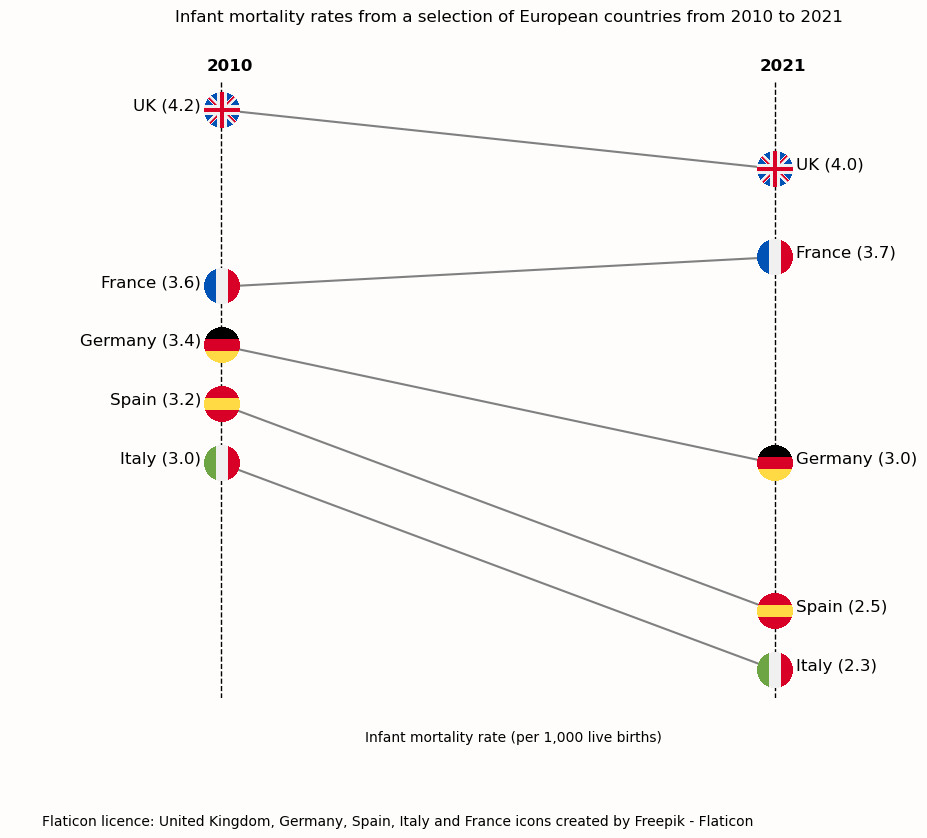

In [18]:
pivoted_EU = EU_UK.pivot(index='Reference area', columns='TIME_PERIOD', values='OBS_VALUE')


# flag files
country_to_flag = {
    'United Kingdom': 'united-kingdom.png',
    'France': 'france.png',
    'Germany': 'germany.png',
    'Spain': 'spain.png',
    'Italy': 'italy.png'
}


def add_label(country_name, year):
    # round infant mortality value
    
    name = 'UK' if country_name == 'United Kingdom' else country_name
    y_pos = round(pivoted_EU.at[country_name, year], 2)
    
    # text position
    x_pos = year - 0.4 if year == 2010 else year + 0.42
    alignment = 'right' if year == 2010 else 'left'
    
    # Adding the annotation
    plt.annotate(
        f'{name} ({y_pos})', 
        xy=(year, y_pos), 
        xytext=(x_pos, y_pos),
        textcoords='data',
        fontsize=12,
        ha=alignment,
        color='black', 
        arrowprops=dict(arrowstyle='->', lw=0.5) 
    )


plt.figure(figsize=(10, 8),facecolor="#FEFDFC")
ax = plt.gca()
plt.xlim(2005.8, 2021.2)


plt.axvline(x=years[0], color='black', linestyle='--', linewidth=1)
plt.axvline(x=years[1], color='black', linestyle='--', linewidth=1)
plt.text(2009.7, pivoted_EU.values.max() + 0.07*pivoted_EU.values.ptp(),
         '2010', fontsize=12, color='black', fontweight='bold')
plt.text(2020.7, pivoted_EU.values.max() + 0.07*pivoted_EU.values.ptp(), 
         '2021', fontsize=12, color='black', fontweight='bold')

for continent in pivoted_EU.index:

    plt.plot(years, pivoted_EU.loc[continent], marker='o', label=continent, 
             color='grey')


for continent_name in pivoted_EU.index:
    for year in years:
        add_label(continent_name, year)
        y_pos = pivoted_EU.at[continent_name, year]
        add_flag(ax, continent_name, year, y_pos)


plt.title(f'Infant mortality rates from a selection of European countries from {years[0]} to {years[1]}  \n\n\n',
          loc="center",x=0.65)

plt.xlabel('Infant mortality rate (per 1,000 live births)', labelpad=20, x=0.65)
plt.text(0.5, -0.2, 'Flaticon licence: United Kingdom, Germany, Spain, Italy and France icons created by Freepik - Flaticon', 
         ha='center', va='center', transform=plt.gca().transAxes)

plt.yticks([])  
plt.xticks([])
plt.box(False) 
plt.show()  


Please note for this visualisation code was adapted from https://python-graph-gallery.com/web-slope-chart-matplotlib/

<a href="https://www.flaticon.com/free-icons/france" title="france icons">France icons created by Freepik - Flaticon</a>
<a href="https://www.flaticon.com/free-icons/uk-flag" title="uk flag icons">Uk flag icons created by Freepik - Flaticon</a>
<a href="https://www.flaticon.com/free-icons/germany" title="germany icons">Germany icons created by Freepik - Flaticon</a>
<a href="https://www.flaticon.com/free-icons/spain" title="spain icons">Spain icons created by Freepik - Flaticon</a>
<a href="https://www.flaticon.com/free-icons/italy" title="italy icons">Italy icons created by Freepik - Flaticon</a>

In [19]:
#filtering data
line_years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,  2021]


EU_UK_trend = EU[
    (EU['Reference area'].isin(reference_areas)) &
    (EU['TIME_PERIOD'].isin(line_years))&
    (EU['GESTATION_THRESHOLD']=='NONE')
]


EU_UK_trend = EU_UK_trend[['Reference area', 'TIME_PERIOD', 'OBS_VALUE']]


EU_UK_trend.head()


,Reference area,TIME_PERIOD,OBS_VALUE
473,United Kingdom,2010,4.2
474,United Kingdom,2011,4.2
475,United Kingdom,2012,4.0
476,United Kingdom,2013,3.9
477,United Kingdom,2014,3.9


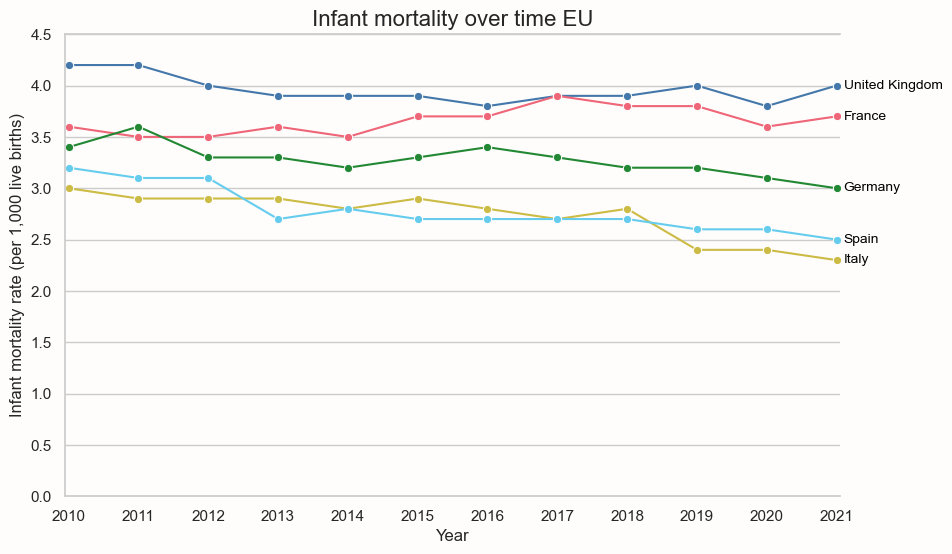

In [20]:
create_line_chart(EU_UK_trend, 
                  x_col='TIME_PERIOD', y_col='OBS_VALUE', hue_col='Reference area', 
                  title='Infant mortality over time EU', xlabel='Year', 
                  ylabel='Infant mortality rate (per 1,000 live births)', ymax=4.5)


# Regions and local authorities

In [21]:
#filtering data
regions= [
    'England',"West Midlands",
    "Yorkshire and The Humber","North West","East Midlands",
    "North East","East","London","South East","South West"]
regional_births = all_births[
    (all_births['GEOGRAPHY_NAME'].isin(regions) ) &
    (all_births['MEASURE_NAME'] == "Live births") 
]

regional_births.reset_index(drop=True, inplace=True)

regional_births

,DATE,GEOGRAPHY_NAME,GEOGRAPHY_CODE,MEASURE_NAME,MEASURES_NAME,OBS_VALUE
0,2013,England,E92000001,Live births,Value,664517
1,2013,East,E12000006,Live births,Value,71309
2,2013,East Midlands,E12000004,Live births,Value,52895
3,2013,London,E12000007,Live births,Value,128332
4,2013,North East,E12000001,Live births,Value,28961
...,...,...,...,...,...,...
95,2022,North West,E12000002,Live births,Value,76399
96,2022,South East,E12000008,Live births,Value,90589
97,2022,South West,E12000009,Live births,Value,48947
98,2022,West Midlands,E12000005,Live births,Value,63368


In [22]:
#cleaning deaths data
regional_births_copy= regional_births.copy()
regional_births_copy = regional_births_copy[['DATE','GEOGRAPHY_NAME','GEOGRAPHY_CODE', 'OBS_VALUE']]


regional_births_copy.rename(columns={'OBS_VALUE': 'live_births'}, inplace=True)

regional_births_copy

,DATE,GEOGRAPHY_NAME,GEOGRAPHY_CODE,live_births
0,2013,England,E92000001,664517
1,2013,East,E12000006,71309
2,2013,East Midlands,E12000004,52895
3,2013,London,E12000007,128332
4,2013,North East,E12000001,28961
...,...,...,...,...
95,2022,North West,E12000002,76399
96,2022,South East,E12000008,90589
97,2022,South West,E12000009,48947
98,2022,West Midlands,E12000005,63368


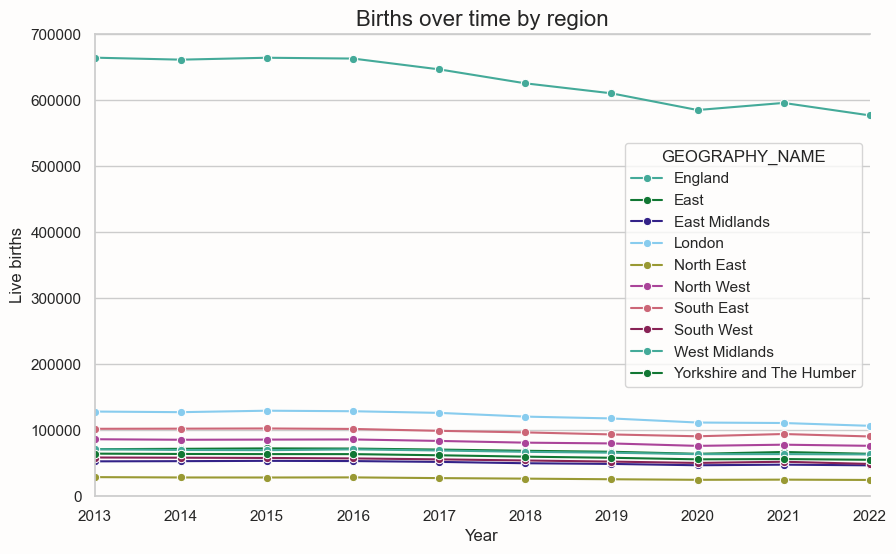

In [23]:
# using muted scheme from TOl
cols={'#332288' , '#88ccee' , '#44aa99'  ,'#117733'  ,'#999933'  ,'#cc6677' ,
      '#882255'  ,'#aa4499'}
create_line_chart(regional_births_copy, x_col='DATE', 
                  y_col='live_births', hue_col='GEOGRAPHY_NAME', title='Births over time by region', 
                  xlabel='Year',ylabel='Live births',legend=True,palette=cols,
                  ymax=700000,xmin=2013,xmax=2022)



In [24]:
#filtering data
regional_deaths = overall_deaths[
    (overall_deaths['GEOGRAPHY_NAME'].isin(regions)) &
    (overall_deaths['CAUSE_OF_DEATH_NAME'] == "A00-R99,U00-Y89 All causes, all ages") &
    (overall_deaths['AGE_NAME'] == "Aged under 1")
]
regional_deaths.reset_index(drop=True, inplace=True)


regional_deaths_copy= regional_deaths.copy()
regional_deaths_copy = regional_deaths_copy[['DATE','GEOGRAPHY_NAME', 'OBS_VALUE']]

regional_deaths_copy.rename(columns={'OBS_VALUE': 'deaths'}, inplace=True)

regional_deaths_copy

,DATE,GEOGRAPHY_NAME,deaths
0,2013,England,2611
1,2013,East,237
2,2013,East Midlands,205
3,2013,London,486
4,2013,North East,92
...,...,...,...
95,2022,North West,340
96,2022,South East,283
97,2022,South West,153
98,2022,West Midlands,344


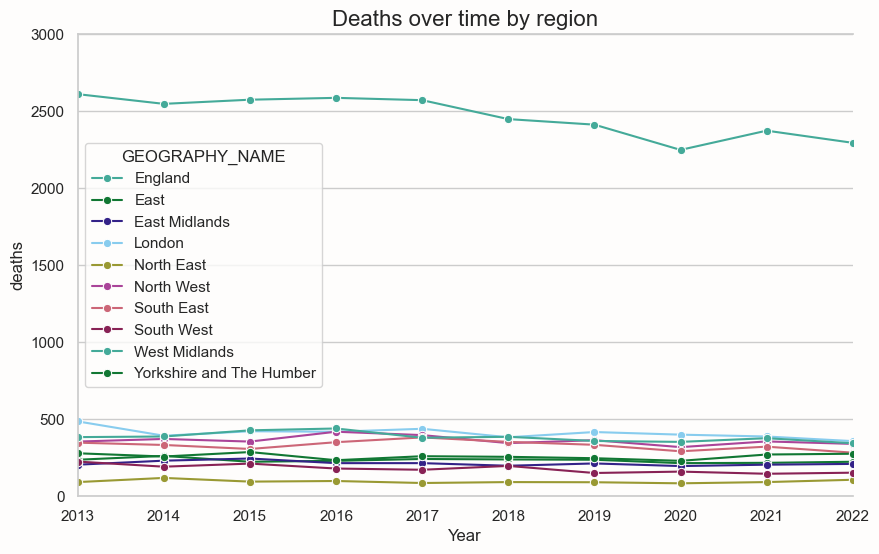

In [25]:
# viewing deaths over time

create_line_chart(
        regional_deaths_copy, 
        x_col='DATE', y_col='deaths', 
        hue_col='GEOGRAPHY_NAME', title='Deaths over time by region', xlabel='Year', ylabel='deaths',
        legend=True,palette=cols,ymax=3000,xmin=2013,xmax=2022)


In [26]:
#merging deaths and births regionally
regional_mort= pd.merge(regional_deaths_copy, regional_births_copy,left_index=True, right_index=True, how='inner') 
regional_mort

,DATE_x,GEOGRAPHY_NAME_x,deaths,DATE_y,GEOGRAPHY_NAME_y,GEOGRAPHY_CODE,live_births
0,2013,England,2611,2013,England,E92000001,664517
1,2013,East,237,2013,East,E12000006,71309
2,2013,East Midlands,205,2013,East Midlands,E12000004,52895
3,2013,London,486,2013,London,E12000007,128332
4,2013,North East,92,2013,North East,E12000001,28961
...,...,...,...,...,...,...,...
95,2022,North West,340,2022,North West,E12000002,76399
96,2022,South East,283,2022,South East,E12000008,90589
97,2022,South West,153,2022,South West,E12000009,48947
98,2022,West Midlands,344,2022,West Midlands,E12000005,63368


In [27]:
#adding confidence intervals
byars_ci(regional_mort,'deaths','live_births')

,DATE_x,GEOGRAPHY_NAME_x,deaths,DATE_y,GEOGRAPHY_NAME_y,GEOGRAPHY_CODE,live_births,Infant mortality rate,lower_ci,upper_ci
0,2013,England,2611,2013,England,E92000001,664517,3.929170,3.779888,4.082835
1,2013,East,237,2013,East,E12000006,71309,3.323564,2.913848,3.774747
2,2013,East Midlands,205,2013,East Midlands,E12000004,52895,3.875603,3.363175,4.444021
3,2013,London,486,2013,London,E12000007,128332,3.787052,3.457796,4.139205
4,2013,North East,92,2013,North East,E12000001,28961,3.176686,2.560789,3.895964
...,...,...,...,...,...,...,...,...,...,...
95,2022,North West,340,2022,North West,E12000002,76399,4.450320,3.989782,4.949429
96,2022,South East,283,2022,South East,E12000008,90589,3.124000,2.770584,3.510000
97,2022,South West,153,2022,South West,E12000009,48947,3.125830,2.650126,3.662254
98,2022,West Midlands,344,2022,West Midlands,E12000005,63368,5.428607,4.870019,6.033694


In [28]:
#adding benchmark
benchmark(regional_mort, 'GEOGRAPHY_NAME_x', 'England', 'deaths')

,DATE_x,GEOGRAPHY_NAME_x,deaths,DATE_y,GEOGRAPHY_NAME_y,GEOGRAPHY_CODE,live_births,Infant mortality rate,lower_ci,upper_ci,benchmark
0,2013,England,2611,2013,England,E92000001,664517,3.929170,3.779888,4.082835,Not comparable
1,2013,East,237,2013,East,E12000006,71309,3.323564,2.913848,3.774747,better
2,2013,East Midlands,205,2013,East Midlands,E12000004,52895,3.875603,3.363175,4.444021,similar
3,2013,London,486,2013,London,E12000007,128332,3.787052,3.457796,4.139205,similar
4,2013,North East,92,2013,North East,E12000001,28961,3.176686,2.560789,3.895964,similar
...,...,...,...,...,...,...,...,...,...,...,...
95,2022,North West,340,2022,North West,E12000002,76399,4.450320,3.989782,4.949429,similar
96,2022,South East,283,2022,South East,E12000008,90589,3.124000,2.770584,3.510000,better
97,2022,South West,153,2022,South West,E12000009,48947,3.125830,2.650126,3.662254,better
98,2022,West Midlands,344,2022,West Midlands,E12000005,63368,5.428607,4.870019,6.033694,worse


In [29]:
# checking values
regional_mort[regional_mort["GEOGRAPHY_NAME_x"]=="England"]

,DATE_x,GEOGRAPHY_NAME_x,deaths,DATE_y,GEOGRAPHY_NAME_y,GEOGRAPHY_CODE,live_births,Infant mortality rate,lower_ci,upper_ci,benchmark
0,2013,England,2611,2013,England,E92000001,664517,3.929170,3.779888,4.082835,Not comparable
10,2014,England,2548,2014,England,E92000001,661499,3.851858,3.703733,4.004387,Not comparable
20,2015,England,2575,2015,England,E92000001,664399,3.875683,3.727418,4.028333,Not comparable
30,2016,England,2587,2016,England,E92000001,663157,3.901037,3.752145,4.054322,Not comparable
40,2017,England,2572,2017,England,E92000001,646794,3.976537,3.824326,4.133252,Not comparable
50,2018,England,2449,2018,England,E92000001,625651,3.914323,3.760814,4.072490,Not comparable
60,2019,England,2413,2019,England,E92000001,610505,3.952466,3.796320,4.113384,Not comparable
70,2020,England,2249,2020,England,E92000001,585195,3.843163,3.685954,4.005354,Not comparable
80,2021,England,2374,2021,England,E92000001,595948,3.983569,3.824920,4.147108,Not comparable
90,2022,England,2295,2022,England,E92000001,577046,3.977153,3.816084,4.143272,Not comparable


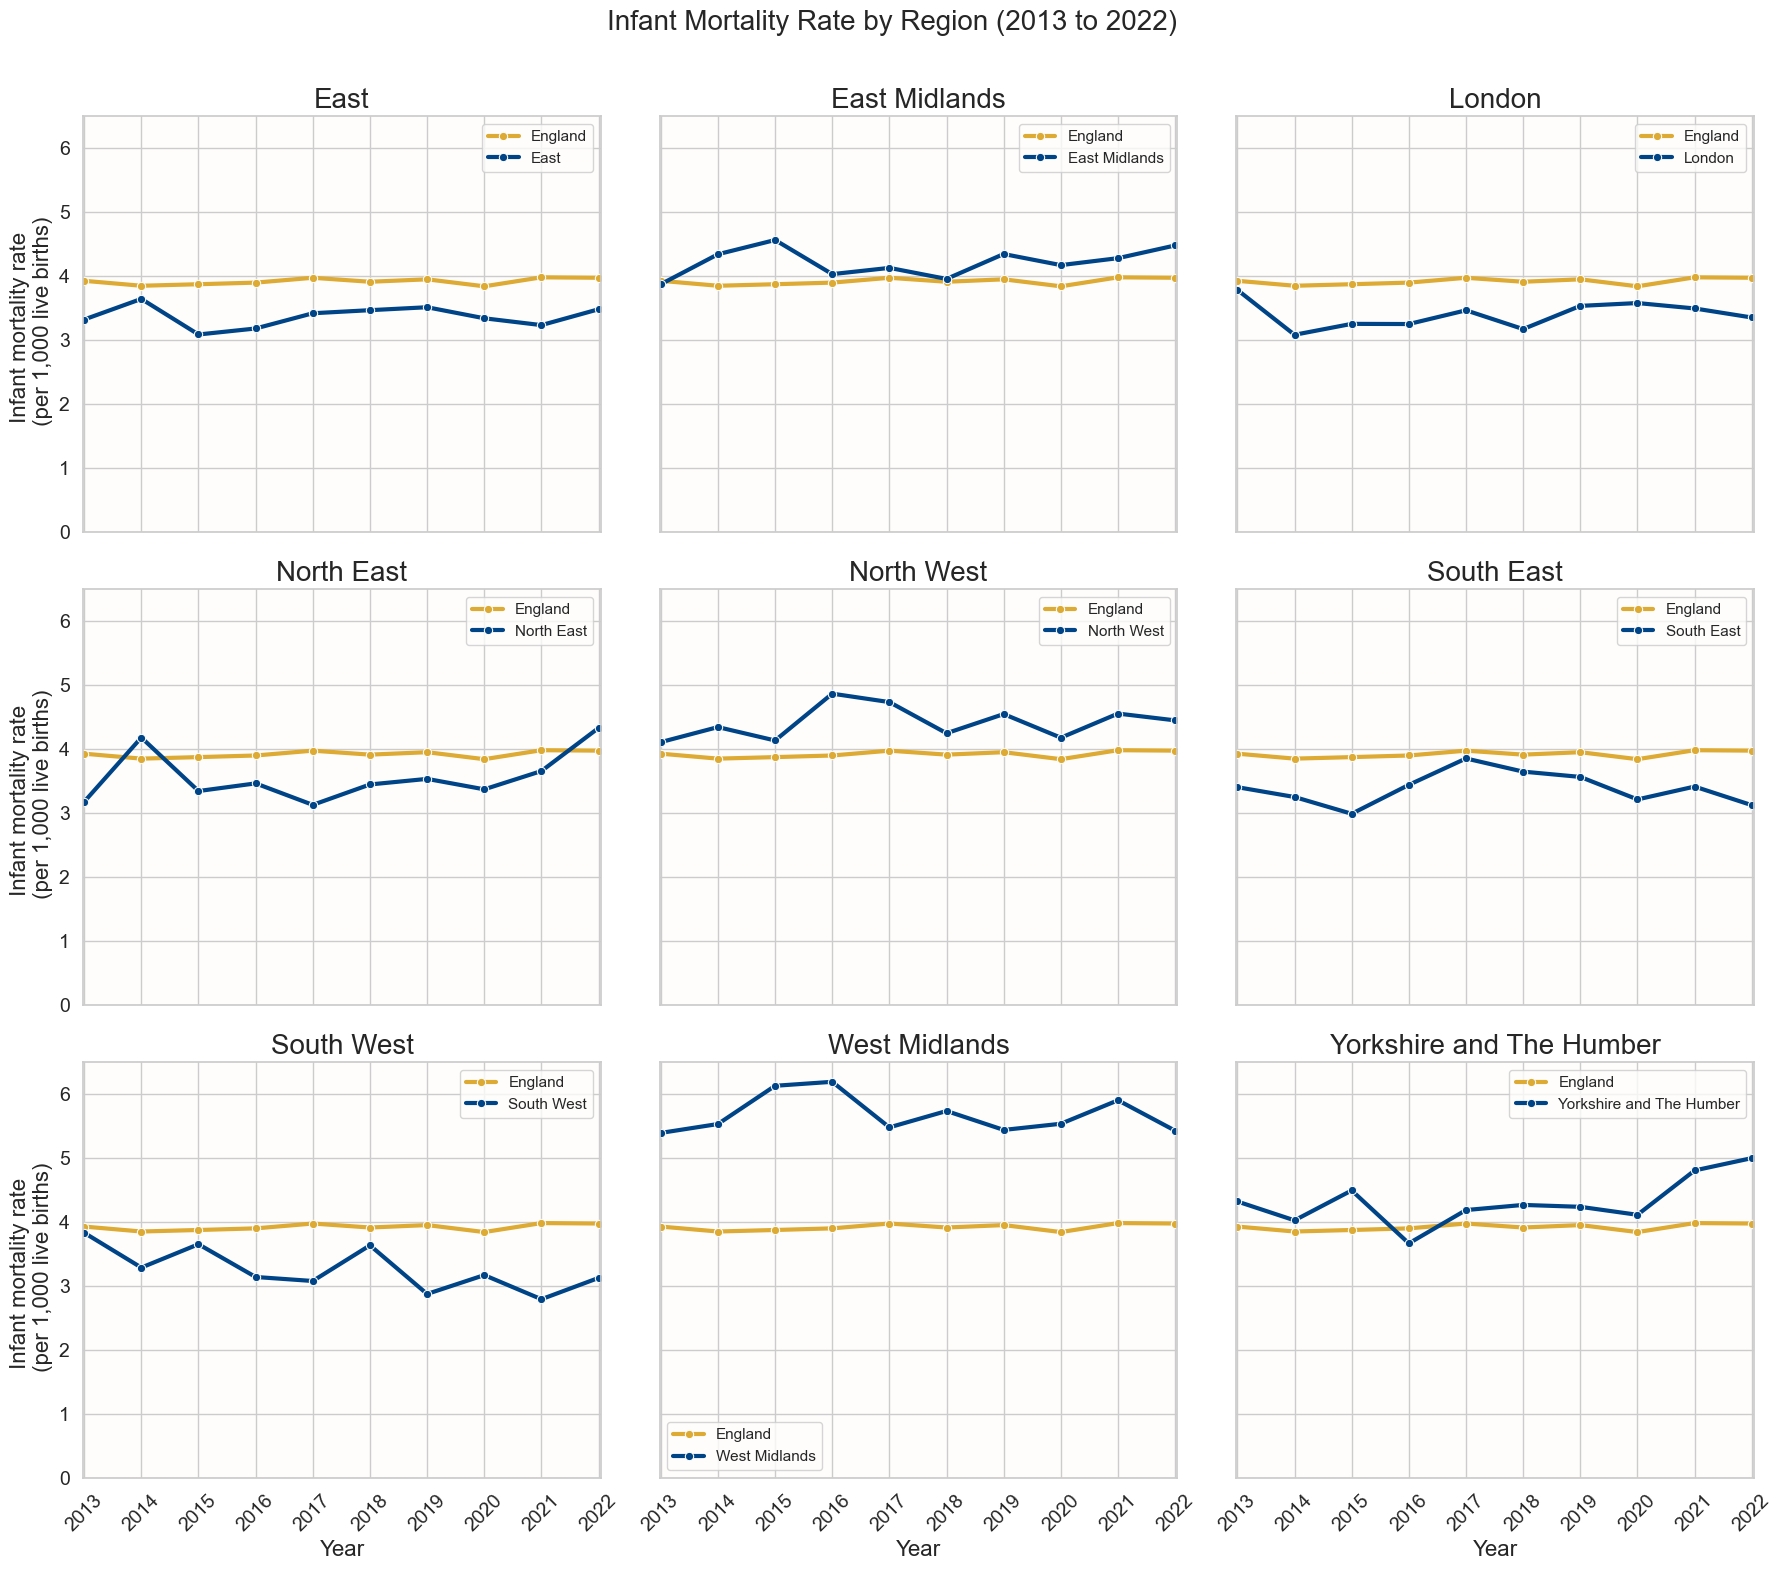

In [30]:
# creating subplots due to there being 9 regions and England
region_line = regional_mort['GEOGRAPHY_NAME_x'].unique().tolist()
region_line.remove('England')

fig, axes = plt.subplots(3, 3, figsize=(18, 16), sharex=True, sharey=True)
fig.suptitle('Infant Mortality Rate by Region (2013 to 2022)', fontsize=20)

for ax, region in zip(axes.flatten(), region_line):
    sns.lineplot(data=regional_mort[regional_mort['GEOGRAPHY_NAME_x'] == 'England'], x='DATE_x', y='Infant mortality rate', label='England',
                 color="#DDAA33",ax=ax, marker='o',
                linewidth=3)
    sns.lineplot(data=regional_mort[regional_mort['GEOGRAPHY_NAME_x'] == region], x='DATE_x',
                 y='Infant mortality rate',
                 label=region, ax=ax, marker='o',
                linewidth=3,color="#004488")
    ax.set_title(region,fontsize=20)
    ax.set_xlabel('Year',fontsize=16)
    ax.set_ylabel('Infant mortality rate \n (per 1,000 live births)',fontsize=16)
    #ax.ylim(0,6.5)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='both',  labelsize=14)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_facecolor("#FEFDFC")
    ax.legend()
plt.ylim(0,6.5)
plt.xlim(2012.98,2022.04)
plt.xticks(regional_mort['DATE_x'].unique().tolist())

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

In [31]:
# filtering for West Midlands

overall_deaths= overall_deaths[['DATE', 'GEOGRAPHY_NAME',
                        'GEOGRAPHY_CODE', 'MEASURE_NAME','CAUSE_OF_DEATH_NAME',
                      'AGE_NAME', 'OBS_VALUE']].rename(columns={'OBS_VALUE': 'Deaths'})

all_births= all_births[['DATE', 'GEOGRAPHY_NAME',
                        'GEOGRAPHY_CODE', 'MEASURE_NAME', 'OBS_VALUE']].rename(columns={'OBS_VALUE': 'Live births'})


WM_ref=['Birmingham','Coventry','Dudley','Herefordshire, County of',
    'Sandwell','Shropshire','Solihull', 'Staffordshire', 'Stoke-on-Trent',
    'Telford and Wrekin', 'Walsall', 'Warwickshire','Wolverhampton','Worcestershire','England']
WM_deaths=overall_deaths[
    (overall_deaths['GEOGRAPHY_NAME'].isin(WM_ref)) &
    (overall_deaths['CAUSE_OF_DEATH_NAME'] == "A00-R99,U00-Y89 All causes, all ages") &
    (overall_deaths['AGE_NAME'] == "Aged under 1")
]
WM_deaths.reset_index(drop=True)

,DATE,GEOGRAPHY_NAME,GEOGRAPHY_CODE,MEASURE_NAME,CAUSE_OF_DEATH_NAME,AGE_NAME,Deaths
0,2013,Birmingham,E08000025,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,130
1,2013,Coventry,E08000026,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,20
2,2013,Dudley,E08000027,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,10
3,2013,"Herefordshire, County of",E06000019,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,5
4,2013,Sandwell,E08000028,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,35
...,...,...,...,...,...,...,...
145,2022,Walsall,E08000030,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,15
146,2022,Warwickshire,E10000031,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,24
147,2022,Wolverhampton,E08000031,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,21
148,2022,Worcestershire,E10000034,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,19


In [32]:
WM_births= all_births[
    (all_births['GEOGRAPHY_NAME'].isin(WM_ref)) &
    (all_births['MEASURE_NAME'] == "Live births") ]

WM_births.reset_index(drop=True)

,DATE,GEOGRAPHY_NAME,GEOGRAPHY_CODE,MEASURE_NAME,Live births
0,2013,Birmingham,E08000025,Live births,17421
1,2013,Coventry,E08000026,Live births,4495
2,2013,Dudley,E08000027,Live births,3853
3,2013,"Herefordshire, County of",E06000019,Live births,1833
4,2013,Sandwell,E08000028,Live births,4844
...,...,...,...,...,...
145,2022,Walsall,E08000030,Live births,3502
146,2022,Warwickshire,E10000031,Live births,5757
147,2022,Wolverhampton,E08000031,Live births,3323
148,2022,Worcestershire,E10000034,Live births,5334


In [33]:
WM = pd.merge(WM_births, WM_deaths, on=['GEOGRAPHY_CODE', 'DATE'])
WM

,DATE,GEOGRAPHY_NAME_x,GEOGRAPHY_CODE,MEASURE_NAME_x,Live births,GEOGRAPHY_NAME_y,MEASURE_NAME_y,CAUSE_OF_DEATH_NAME,AGE_NAME,Deaths
0,2013,Birmingham,E08000025,Live births,17421,Birmingham,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,130
1,2013,Coventry,E08000026,Live births,4495,Coventry,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,20
2,2013,Dudley,E08000027,Live births,3853,Dudley,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,10
3,2013,"Herefordshire, County of",E06000019,Live births,1833,"Herefordshire, County of",Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,5
4,2013,Sandwell,E08000028,Live births,4844,Sandwell,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,35
...,...,...,...,...,...,...,...,...,...,...
145,2022,Walsall,E08000030,Live births,3502,Walsall,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,15
146,2022,Warwickshire,E10000031,Live births,5757,Warwickshire,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,24
147,2022,Wolverhampton,E08000031,Live births,3323,Wolverhampton,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,21
148,2022,Worcestershire,E10000034,Live births,5334,Worcestershire,Deaths,"A00-R99,U00-Y89 All causes, all ages",Aged under 1,19


In [34]:
# grouping by two years
WM_multiple_births = two_year_combo(WM_births, "DATE", "Live births", grouped=['GEOGRAPHY_NAME', 'GEOGRAPHY_CODE'])
WM_multiple_deaths = two_year_combo(WM_deaths, "DATE", "Deaths", grouped=['GEOGRAPHY_NAME', 'GEOGRAPHY_CODE'])



In [35]:
WM=pd.merge(WM_multiple_births, WM_multiple_deaths, on=['GEOGRAPHY_CODE', 'Interval'])

In [36]:
byars_ci(WM, "Deaths","Live births")
benchmark(WM, 'GEOGRAPHY_NAME_x', 'England', 'Deaths')

,Interval,GEOGRAPHY_NAME_x,GEOGRAPHY_CODE,Live births,GEOGRAPHY_NAME_y,Deaths,Infant mortality rate,lower_ci,upper_ci,benchmark
0,2013-2014,Birmingham,E08000025,34348,Birmingham,253,7.365785,6.486009,8.331594,worse
1,2013-2014,Coventry,E08000026,9067,Coventry,36,3.970442,2.780462,5.496929,similar
2,2013-2014,Dudley,E08000027,7611,Dudley,26,3.416108,2.230949,5.005590,similar
3,2013-2014,England,E92000001,1326016,England,5159,3.890602,3.785152,3.998244,Not comparable
4,2013-2014,"Herefordshire, County of",E06000019,3561,"Herefordshire, County of",14,3.931480,2.147580,6.596742,low reliability
...,...,...,...,...,...,...,...,...,...,...
130,2021-2022,Telford and Wrekin,E06000020,3975,Telford and Wrekin,24,6.037736,3.867351,8.984054,similar
131,2021-2022,Walsall,E08000030,7031,Walsall,35,4.977955,3.466820,6.923341,similar
132,2021-2022,Warwickshire,E10000031,11755,Warwickshire,55,4.678860,3.524528,6.090295,similar
133,2021-2022,Wolverhampton,E08000031,6565,Wolverhampton,31,4.722011,3.207790,6.702746,similar


In [37]:
WM_rec=WM[
    (WM['GEOGRAPHY_NAME_x'] !="England") &
    (WM['Interval'] == '2021-2022')
]
WM_rec

,Interval,GEOGRAPHY_NAME_x,GEOGRAPHY_CODE,Live births,GEOGRAPHY_NAME_y,Deaths,Infant mortality rate,lower_ci,upper_ci,benchmark
120,2021-2022,Birmingham,E08000025,28959,Birmingham,227,7.838668,6.852006,8.927488,worse
121,2021-2022,Coventry,E08000026,8007,Coventry,47,5.869864,4.312584,7.805851,worse
122,2021-2022,Dudley,E08000027,6865,Dudley,28,4.078660,2.709641,5.895020,similar
124,2021-2022,"Herefordshire, County of",E06000019,3107,"Herefordshire, County of",7,2.252977,0.905814,4.641994,low reliability
125,2021-2022,Sandwell,E08000028,8557,Sandwell,56,6.544350,4.943219,8.498541,worse
126,2021-2022,Shropshire,E06000051,5206,Shropshire,18,3.457549,2.048117,5.464702,low reliability
127,2021-2022,Solihull,E08000029,4053,Solihull,15,3.700962,2.069890,6.104523,low reliability
128,2021-2022,Staffordshire,E10000028,16301,Staffordshire,82,5.030366,4.000669,6.244086,worse
129,2021-2022,Stoke-on-Trent,E06000021,6026,Stoke-on-Trent,53,8.795221,6.587765,11.504593,worse
130,2021-2022,Telford and Wrekin,E06000020,3975,Telford and Wrekin,24,6.037736,3.867351,8.984054,similar


bringing in booundary data for maps, data is not saved saved locally as these boundarys will not be updates

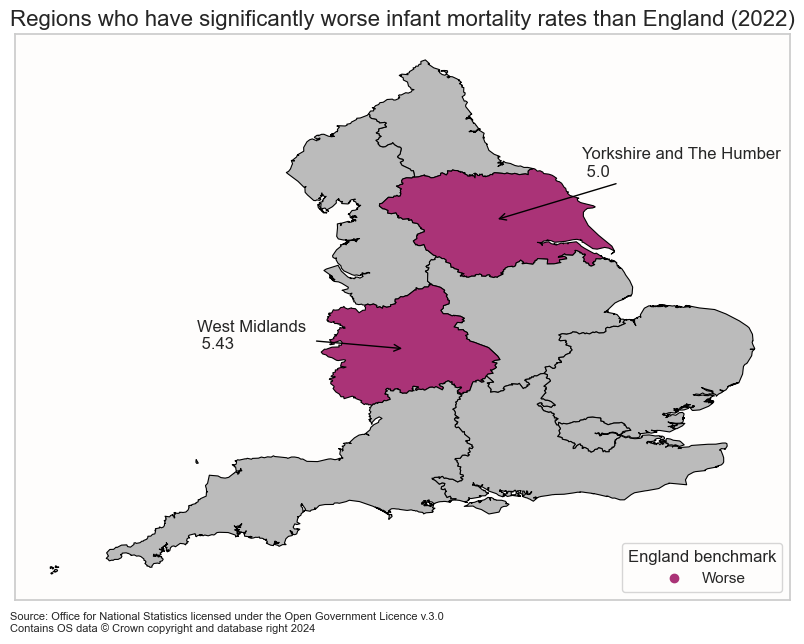

In [38]:


eng_url = 'https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Regions_December_2023_Boundaries_EN_BUC/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'
response = requests.get(eng_url)
eng_data = response.json()

# removing england
reg_map = regional_mort[
    (regional_mort['GEOGRAPHY_NAME_x'].isin(regions)) &
    (regional_mort['DATE_x'] == 2022)
]


# putting map in data form ready for linkahe
eng = gpd.GeoDataFrame.from_features(eng_data["features"])
eng = eng.rename(columns={"RGN23CD": "GEOGRAPHY_CODE"})
eng_mort = eng.merge(reg_map, on="GEOGRAPHY_CODE")

colour_map = {'worse': '#AA3377', 'better': '#BBBBBB',
             'similar':'#BBBBBB', 'low reliability': "#BBBBBB"}

# benchmark for colours
fig, ax = plt.subplots(figsize=(10, 10))
eng_mort.plot(color=[colour_map[c] for c in eng_mort['benchmark']], 
                linewidth=0.8, ax=ax, edgecolor='black')

# text placements
for idx, row in eng_mort.iterrows():
    if row['benchmark'] == 'worse':
        if row['RGN23NM'] == 'West Midlands':
            xytext = (row.geometry.centroid.x - 2.4, row.geometry.centroid.y + 0)
        else:
            xytext = (row.geometry.centroid.x +1, row.geometry.centroid.y + 0.5)
        ax.annotate(text=f"{row['RGN23NM']} \n {round(row['Infant mortality rate'],2)}",
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    xytext=xytext,
                    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->'),
                    fontsize=12)

# only show WOrse
legend_labels = {'worse': 'Worse'}
handles = [plt.Line2D([0], [0], color=colour_map[c], marker='o', linestyle='', label=legend_labels[c]) for c in ['worse']]

ax.legend(handles=handles, title='England benchmark', loc='lower right')
ax.set_title('Regions who have significantly worse infant mortality rates than England (2022)',fontsize=16)
ax.set_yticks([])
ax.set_xticks([])
caption_text = "Source: Office for National Statistics licensed under the Open Government Licence v.3.0\nContains OS data © Crown copyright and database right 2024"
fig.text(0.12, 0.18, caption_text, ha='left', fontsize=8)
plt.show()

In [39]:
# Yorkshire and the humber cleaning 

YH_ref=['Barnsley','Bradford', 'Calderdale','Doncaster','East Riding of Yorkshire','Kingston upon Hull, City of','Kirklees',
    'Leeds','North East Lincolnshire','North Lincolnshire' ,
    'North Yorkshire' ,'Rotherham','Sheffield','Wakefield','York','England']
YH_deaths=overall_deaths[
    (overall_deaths['GEOGRAPHY_NAME'].isin(YH_ref)) &
    (overall_deaths['CAUSE_OF_DEATH_NAME'] == "A00-R99,U00-Y89 All causes, all ages") &
    (overall_deaths['AGE_NAME'] == "Aged under 1")
]
YH_deaths.reset_index(drop=True)
YH_births= all_births[
    (all_births['GEOGRAPHY_NAME'].isin(YH_ref)) &
    (all_births['MEASURE_NAME'] == "Live births") ]

YH_births.reset_index(drop=True)
YH_multiple_b = two_year_combo(YH_births, "DATE", "Live births", grouped=['GEOGRAPHY_NAME', 'GEOGRAPHY_CODE'])
YH_multiple_d = two_year_combo(YH_deaths, "DATE", "Deaths", grouped=['GEOGRAPHY_NAME', 'GEOGRAPHY_CODE'])
YH=pd.merge(YH_multiple_b, YH_multiple_d, on=['GEOGRAPHY_CODE', 'Interval'])
byars_ci(YH, "Deaths","Live births")
benchmark(YH, 'GEOGRAPHY_NAME_x', 'England', 'Deaths')

YH_rec=YH[
    (YH['GEOGRAPHY_NAME_x'] !="England") &
    (YH['Interval'] == '2021-2022')
]
YH_rec

,Interval,GEOGRAPHY_NAME_x,GEOGRAPHY_CODE,Live births,GEOGRAPHY_NAME_y,Deaths,Infant mortality rate,lower_ci,upper_ci,benchmark
128,2021-2022,Barnsley,E08000016,5046,Barnsley,27,5.350773,3.525360,7.785394,similar
129,2021-2022,Bradford,E08000032,13512,Bradford,99,7.326821,5.954738,8.920226,worse
130,2021-2022,Calderdale,E08000033,4088,Calderdale,16,3.913894,2.235692,6.356272,low reliability
131,2021-2022,Doncaster,E08000017,6683,Doncaster,38,5.686069,4.023293,7.804793,worse
132,2021-2022,East Riding of Yorkshire,E06000011,5184,East Riding of Yorkshire,15,2.893519,1.618299,4.772691,low reliability
134,2021-2022,"Kingston upon Hull, City of",E06000010,6188,"Kingston upon Hull, City of",25,4.040078,2.613812,5.964197,similar
135,2021-2022,Kirklees,E08000034,9528,Kirklees,54,5.667506,4.257318,7.395010,worse
136,2021-2022,Leeds,E08000035,17401,Leeds,86,4.942245,3.953039,6.103701,similar
137,2021-2022,North East Lincolnshire,E06000012,2988,North East Lincolnshire,13,4.350736,2.314338,7.440337,low reliability
138,2021-2022,North Lincolnshire,E06000013,3147,North Lincolnshire,16,5.084207,2.904197,8.256892,low reliability


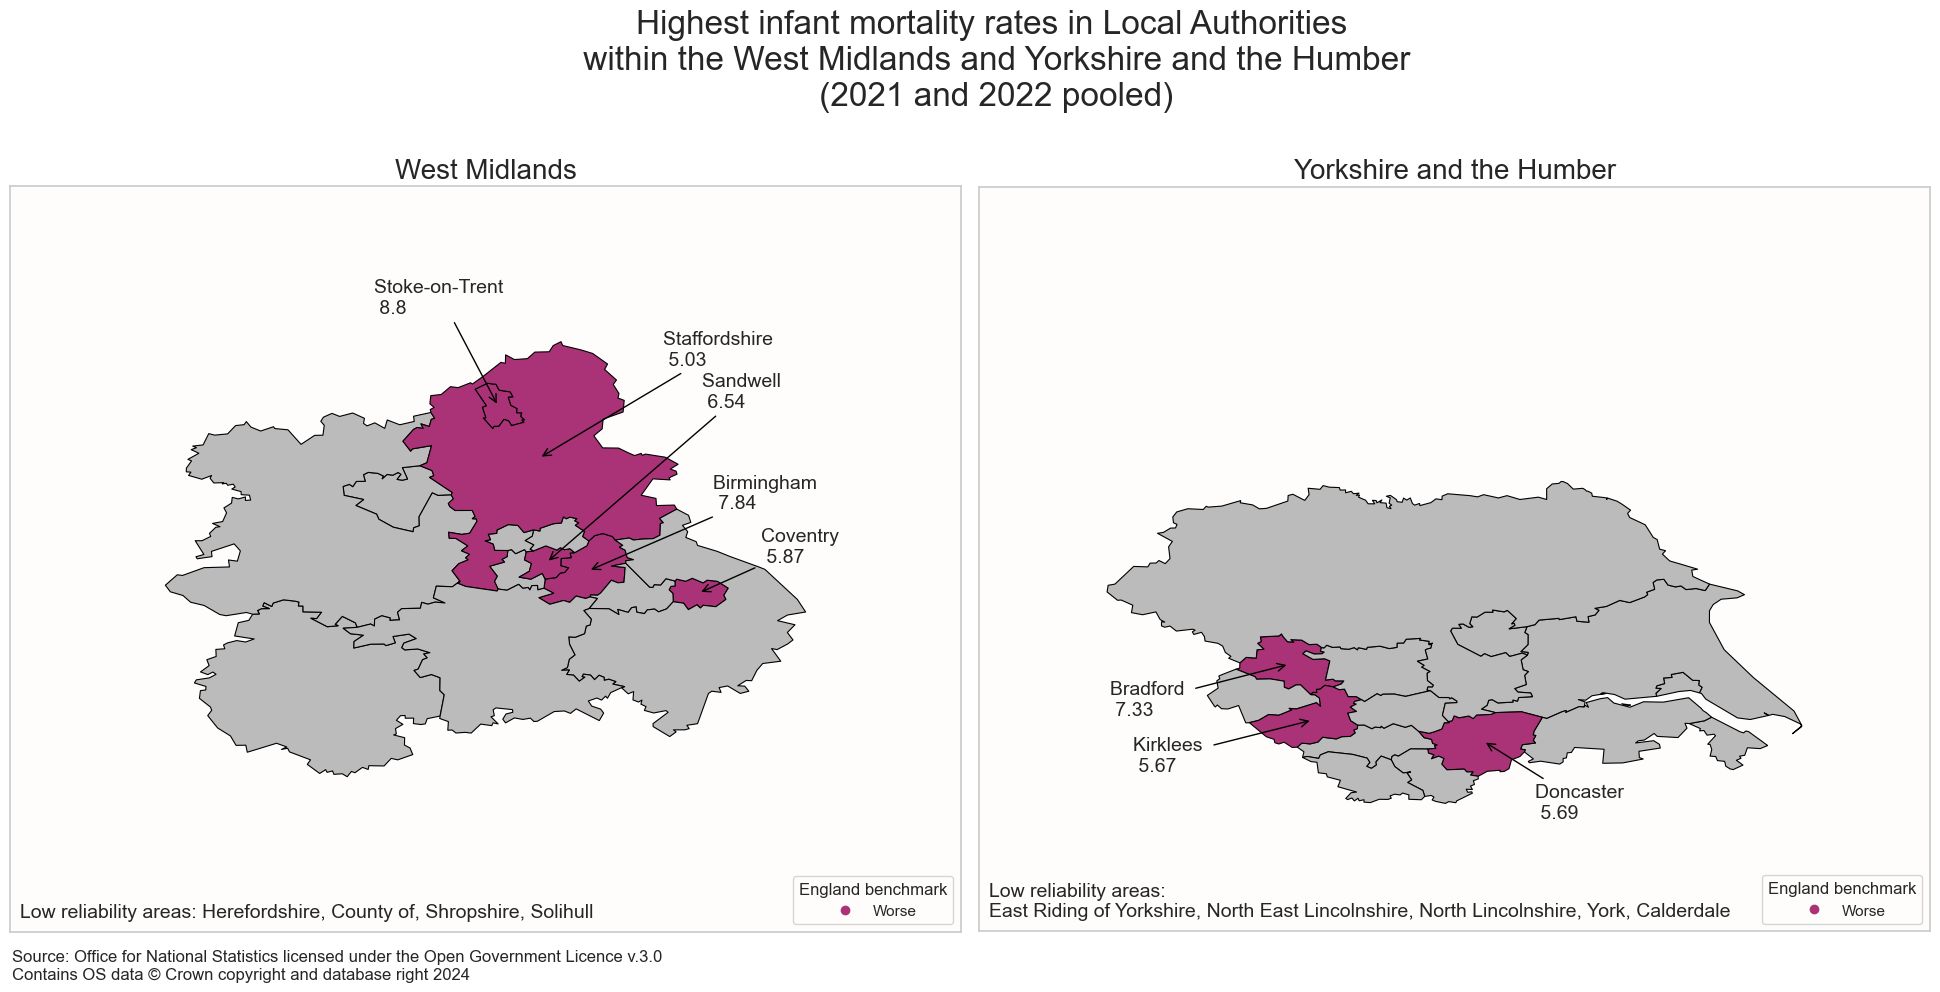

In [40]:
# local authority map
LA_url = 'https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Counties_and_Unitary_Authorities_December_2021_EN_BUC/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'
la_response = requests.get(LA_url)
la_data = la_response.json()

la_map_df= gpd.GeoDataFrame.from_features(la_data["features"])
la_map_df = la_map_df.rename(columns={"CTYUA21CD": "GEOGRAPHY_CODE"})

# merging map onto latest data
wm_map=la_map_df.merge(WM_rec, on="GEOGRAPHY_CODE")
yh_map=la_map_df.merge(YH_rec, on="GEOGRAPHY_CODE")

# Using grid spec to have more control over size
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1]) 

# WM
ax1 = fig.add_subplot(gs[0, 0])
wm_map.plot(color=[colour_map[c] for c in wm_map['benchmark']], 
    linewidth=0.8, ax=ax1, edgecolor='black'
)

# making WM gridbox same size
ax1.set_xlim(wm_map.total_bounds[0] - 0.5, wm_map.total_bounds[2] + 0.5)
ax1.set_ylim(wm_map.total_bounds[1] - 0.5, wm_map.total_bounds[3] + 0.5)

# text mappint
for idx, row in wm_map.iterrows():
    if row['benchmark'] == 'worse':
        if row['CTYUA21NM'] == 'Coventry':  
            xytext = (row.geometry.centroid.x + 0.2, row.geometry.centroid.y + 0.1)
        elif row['CTYUA21NM'] == 'Sandwell':  
            xytext = (row.geometry.centroid.x + .5, row.geometry.centroid.y + .5)
        elif row['CTYUA21NM'] == 'Stoke-on-Trent':  
            xytext = (row.geometry.centroid.x - 0.4, row.geometry.centroid.y + 0.3)             
        elif row['CTYUA21NM'] == 'Staffordshire':  
            xytext = (row.geometry.centroid.x + 0.4, row.geometry.centroid.y + 0.3) 
        else:
            xytext = (row.geometry.centroid.x + 0.4, row.geometry.centroid.y + 0.2)
        ax1.annotate(
            text=f"{row['CTYUA21NM']} \n {round(row['Infant mortality rate'], 2)}",
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            xytext=xytext,
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->'),
            fontsize=14)

# yoekshire
ax2 = fig.add_subplot(gs[0, 1])
yh_map.plot(color=[colour_map[c] for c in yh_map['benchmark']], 
    linewidth=0.8, ax=ax2, edgecolor='black'
)

# making the boxes the same size
ax2.set_xlim(yh_map.total_bounds[0] - 0.5, yh_map.total_bounds[2] + 0.5)
ax2.set_ylim(yh_map.total_bounds[1] - 0.5, yh_map.total_bounds[3] + 1.15)

# text mapping
for idx, row in yh_map.iterrows():
    if row['benchmark'] == 'worse':
        if row['CTYUA21NM'] == 'Doncaster':  
            xytext = (row.geometry.centroid.x + 0.2, row.geometry.centroid.y - 0.3)
        elif row.geometry.centroid.x > 0:  
            xytext = (row.geometry.centroid.x - 0.8, row.geometry.centroid.y)
        else:
            xytext = (row.geometry.centroid.x - 0.7, row.geometry.centroid.y - 0.2)
        ax2.annotate(
            text=f"{row['CTYUA21NM']} \n {round(row['Infant mortality rate'], 2)}",
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            xytext=xytext,
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->'),
            fontsize=14)

legend_labels = {'worse': 'Worse'}
handles = [plt.Line2D([0], [0], color=colour_map[c], marker='o', linestyle='', label=legend_labels[c]) for c in ['worse']]

ax1.legend(handles=handles, title='England benchmark', loc='lower right')
ax2.legend(handles=handles, title='England benchmark', loc='lower right')

ax1.set_title('West Midlands',fontsize=20)
ax2.set_title('Yorkshire and the Humber',fontsize=20)
# text for charts
lowrel=wm_map['CTYUA21NM'][wm_map['benchmark'] == 'low reliability'].tolist()
lowrel2=yh_map['CTYUA21NM'][yh_map['benchmark'] == 'low reliability'].tolist()
disclaimer_text1 = f"Low reliability areas: {', '.join(lowrel)}"
disclaimer_text2 = f"Low reliability areas:\n{', '.join(lowrel2)}"
# disclaimer plotting
ax1.text(0.01, 0.02, disclaimer_text1, fontsize=14, ha='left', transform=ax1.transAxes)
ax2.text(0.01, 0.02, disclaimer_text2, fontsize=14, ha='left', transform=ax2.transAxes)
for ax in [ax1, ax2]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_aspect('equal')

plt.tight_layout()
plt.suptitle("Highest infant mortality rates in Local Authorities\n within the West Midlands and Yorkshire and the Humber\n (2021 and 2022 pooled)", 
             fontsize=24, y=1.05)

fig.text(0.01, 0.0802, caption_text, ha='left', fontsize=12)
plt.show()



## deprivation charts

In [41]:
IMD_merged= pd.merge(deprivation, IMD_births,left_index=True, right_index=True, how='inner')
byars_ci(IMD_merged,'Aged\n0 years','Live births')

,IMD Decile_x,Aged\n0 years,IMD Decile_y,Live births,Infant mortality rate,lower_ci,upper_ci
0,1 (Most deprived),485,1,76738,6.320206,5.770157,6.908546
1,2,354,2,69769,5.073887,4.559026,5.630969
2,3,309,3,66267,4.662954,4.157464,5.212951
3,4,220,4,61221,3.593538,3.134321,4.101094
4,5,217,5,57319,3.78583,3.298823,4.324475
5,6,191,6,55532,3.439458,2.968931,3.963361
6,7,174,7,51596,3.372354,2.889850,3.912369
7,8,137,8,49451,2.770419,2.325918,3.275109
8,9,112,9,47206,2.37258,1.953537,2.854853
9,10 (Least deprived),96,10,41947,2.288602,1.853729,2.794803


In [42]:
national= regional_mort[
    (regional_mort['GEOGRAPHY_NAME_x']=="England") &
    (regional_mort['DATE_x'] == 2022)]
national

,DATE_x,GEOGRAPHY_NAME_x,deaths,DATE_y,GEOGRAPHY_NAME_y,GEOGRAPHY_CODE,live_births,Infant mortality rate,lower_ci,upper_ci,benchmark
90,2022,England,2295,2022,England,E92000001,577046,3.977153,3.816084,4.143272,Not comparable


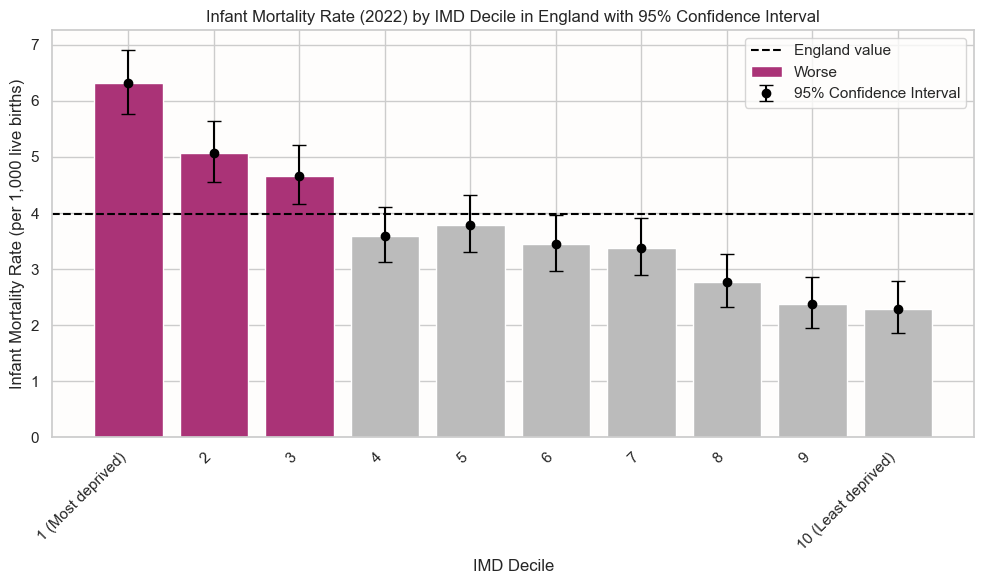

In [43]:

IMD_merged['IMD Decile_x'] = IMD_merged['IMD Decile_x'].astype(str)

plt.figure(figsize=(10, 6))
colours = np.where((IMD_merged['upper_ci'] < national['lower_ci'].values[0]) , '#BBBBBB',
                  np.where((IMD_merged['upper_ci'] > national['lower_ci'].values[0])
                           & (IMD_merged['lower_ci'] < national['upper_ci'].values[0]), '#BBBBBB', '#AA3377'))

bars = plt.bar(IMD_merged['IMD Decile_x'], IMD_merged['Infant mortality rate'], color=colours, label='Worse')

# adding CIs
plt.errorbar(IMD_merged['IMD Decile_x'], IMD_merged['Infant mortality rate'],
             yerr=[IMD_merged['Infant mortality rate'] - IMD_merged['lower_ci'], IMD_merged['upper_ci'] - IMD_merged['Infant mortality rate']],
             fmt='o', color='black', capsize=5, label='95% Confidence Interval')

# national line
plt.axhline(y=national['Infant mortality rate'].values[0], color='black', linestyle='--', label='England value')

plt.xlabel('IMD Decile')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
plt.title('Infant Mortality Rate (2022) by IMD Decile in England with 95% Confidence Interval')
plt.xticks(rotation=45, ha='right')  
plt.legend()


plt.tight_layout()
plt.show()

In [44]:
LA_multiple_b = two_year_combo(all_births, "DATE", "Live births",
                               grouped=['GEOGRAPHY_NAME', 'GEOGRAPHY_CODE'])
LA_multiple_d = two_year_combo(overall_deaths[overall_deaths['AGE_NAME'] == "Aged under 1"], "DATE", 
                               "Deaths", grouped=['GEOGRAPHY_NAME', 'GEOGRAPHY_CODE'])

most_rec_LAs =pd.merge(LA_multiple_b,LA_multiple_d, on=['GEOGRAPHY_CODE', 'Interval'])
byars_ci(most_rec_LAs,"Deaths","Live births")


,Interval,GEOGRAPHY_NAME_x,GEOGRAPHY_CODE,Live births,GEOGRAPHY_NAME_y,Deaths,Infant mortality rate,lower_ci,upper_ci
0,2013-2014,Barking and Dagenham,E09000002,7365,Barking and Dagenham,33,4.480652,3.083771,6.292704
1,2013-2014,Barnet,E09000003,10431,Barnet,24,2.300834,1.473753,3.423604
2,2013-2014,Barnsley,E08000016,5596,Barnsley,26,4.646176,3.034267,6.807995
3,2013-2014,Bath and North East Somerset,E06000022,3556,Bath and North East Somerset,10,2.812148,1.346302,5.171951
4,2013-2014,Bedford,E06000055,4224,Bedford,18,4.261364,2.524265,6.735142
...,...,...,...,...,...,...,...,...,...
1453,2021-2022,Wokingham,E06000041,3493,Wokingham,5,1.431434,0.464783,3.340490
1454,2021-2022,Wolverhampton,E08000031,6565,Wolverhampton,31,4.722011,3.207790,6.702746
1455,2021-2022,Worcestershire,E10000034,10807,Worcestershire,41,3.793837,2.722224,5.146903
1456,2021-2022,York,E06000014,3192,York,10,3.132832,1.499828,5.761735


In [45]:
most_rec_LAs=most_rec_LAs[most_rec_LAs['Interval']=="2021-2022"]

In [46]:
# linking deprivation to Infan mort
dep_IMD=IMD[["Upper Tier Local Authority District code (2019)",
             "IMD - Average score "]]
dep_IMD = dep_IMD.rename(columns={"Upper Tier Local Authority District code (2019)": "GEOGRAPHY_CODE",
                                "IMD - Average score ":"IMD_average" })
IMD_LSOA= pd.merge(most_rec_LAs, dep_IMD, on=['GEOGRAPHY_CODE'])

# filtering out counts below 20 due to low reliability
IMD_LSOA= IMD_LSOA[IMD_LSOA['Deaths']>19]

In [47]:
IMD_LSOA[IMD_LSOA['Infant mortality rate']>8]

,Interval,GEOGRAPHY_NAME_x,GEOGRAPHY_CODE,Live births,GEOGRAPHY_NAME_y,Deaths,Infant mortality rate,lower_ci,upper_ci,IMD_average
69,2021-2022,Leicester,E06000016,8548,Leicester,69,8.072064,6.280272,10.215863,30.877
119,2021-2022,Stoke-on-Trent,E06000021,6026,Stoke-on-Trent,53,8.795221,6.587765,11.504593,34.504


## Regression plot

These links were used for assumptions, intepretation

Bobbitt, Z (2020). A Complete Guide to Linear Regression in Python. [online] Statology. Available at: https://www.statology.org/linear-regression-python/.

Bobbitt, Z (2020). How to Perform a Breusch-Pagan Test in Python. [online] Statology. Available at: https://www.statology.org/breusch-pagan-test-python/.


Bobbitt, Z (2020). How to Create a Q-Q Plot in Python. [online] Statology. Available at: https://www.statology.org/q-q-plot-python/.


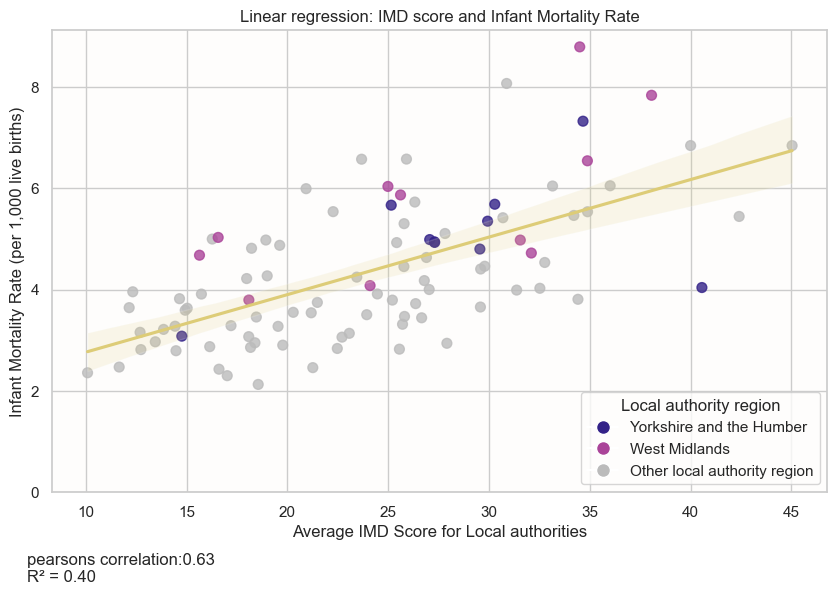

In [48]:


IMD_LSOA['Colour'] = np.where(IMD_LSOA['GEOGRAPHY_NAME_x'].isin(YH_ref), '#332288',
                              np.where(IMD_LSOA['GEOGRAPHY_NAME_x'].isin(WM_ref), '#AA4499', '#BBBBBB'))
y = IMD_LSOA["Infant mortality rate"]

X = IMD_LSOA["IMD_average"]
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()
r_squared = model.rsquared

plt.figure(figsize=(10, 6))
sns.regplot(x='IMD_average', y='Infant mortality rate',
            data=IMD_LSOA, scatter_kws={'s': 50, 'color': IMD_LSOA['Colour'].tolist()}, line_kws={'color': '#DDCC77'})
plt.title('Linear regression: IMD score and Infant Mortality Rate')
plt.xlabel('Average IMD Score for Local authorities')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#332288', markersize=10, label='Yorkshire and the Humber'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#AA4499', markersize=10, label='West Midlands'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#BBBBBB', markersize=10, label='Other local authority region')]


plt.legend(handles=legend_handles, title="Local authority region"
          , loc='lower right')

plt.ylim(0)
plt.grid(True)
plt.figtext(0.1, -0.04,
            f'pearsons correlation:{round(stats.pearsonr(IMD_LSOA["Infant mortality rate"],IMD_LSOA["IMD_average"])[0],2)}\nR² = {r_squared:.2f}')
plt.show()

In [49]:
print(model.summary())
# Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, X)
test_statistic = bp_test[0]
p_value = bp_test[1]

print("Breusch-Pagan test statistics:", test_statistic)
print("Breusch-Pagan test p-value:", p_value)

                              OLS Regression Results                             
Dep. Variable:     Infant mortality rate   R-squared:                       0.400
Model:                               OLS   Adj. R-squared:                  0.394
Method:                    Least Squares   F-statistic:                     63.34
Date:                   Sun, 02 Jun 2024   Prob (F-statistic):           3.68e-12
Time:                           21:23:40   Log-Likelihood:                -143.61
No. Observations:                     97   AIC:                             291.2
Df Residuals:                         95   BIC:                             296.4
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.62

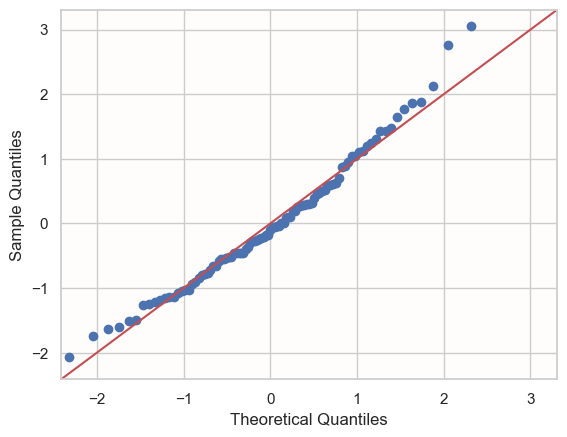

In [50]:
# QQplot for normality cheking
fig = sm.qqplot(model.resid, fit=True, line="45")
plt.show() 

# Ethnicity

In [51]:
# ethnicity cleaning 2020
ethnicity_20= ethnicity_20.assign(Year=2020)
ethnicity_20 = ethnicity_20[ethnicity_20['Country code'] == 'E92000001']
ethnicity_20_copy = ethnicity_20.copy()
ethnicity_20_copy = ethnicity_20_copy.loc[:, ['Year','Ethnic group','Infant deaths','Live births']]
byars_ci(ethnicity_20_copy, 'Infant deaths','Live births')

,Year,Ethnic group,Infant deaths,Live births,Infant mortality rate,lower_ci,upper_ci
14,2020,All,2100,584509,3.592759,3.440723,3.749783
15,2020,Bangladeshi,45,9453,4.760394,3.47194,6.369931
16,2020,Indian,57,21311,2.674675,2.025649,3.465415
17,2020,Pakistani,144,27170,5.299963,4.469632,6.239769
18,2020,Any other Asian background,53,15916,3.329982,2.494212,4.355785
19,2020,Black African,102,20842,4.893964,3.990353,5.940993
20,2020,Black Caribbean,31,5043,6.147135,4.175915,8.725665
21,2020,Any other Black background,23,3648,6.304825,3.995442,9.460748
22,2020,Mixed/ multiple,124,39998,3.100155,2.578507,3.696319
23,2020,Any Other ethnic group,51,13994,3.644419,2.713307,4.791837


In [52]:
#ethnicity cleaning 2021
ethnicity_21= ethnicity_21.assign(Year=2021)
ethnicity_21 = ethnicity_21[ethnicity_21['Country code'] == 'E92000001']
ethnicity_21_copy = ethnicity_21.copy()
ethnicity_21_copy = ethnicity_21_copy.loc[:, ['Year','Ethnic group','Infant deaths','Live births']]
byars_ci(ethnicity_21_copy, 'Infant deaths','Live births')

,Year,Ethnic group,Infant deaths,Live births,Infant mortality rate,lower_ci,upper_ci
14,2021,All,2209,595300,3.710734,3.557588,3.868777
15,2021,Bangladeshi,43,9986,4.306028,3.115979,5.800336
16,2021,Indian,91,22722,4.004929,3.224431,4.917217
17,2021,Pakistani,175,26745,6.543279,5.609665,7.587834
18,2021,Any other Asian background,54,15641,3.452465,2.593423,4.504805
19,2021,Black African,142,20733,6.848985,5.768769,8.07269
20,2021,Black Caribbean,25,5067,4.933886,3.192079,7.283689
21,2021,Any other Black background,26,3733,6.964908,4.548555,10.20561
22,2021,Mixed/ multiple,144,42155,3.415965,2.880795,4.021694
23,2021,Any Other ethnic group,43,13817,3.112108,2.252021,4.192093


In [53]:
ethnicity_comb= pd.concat([ethnicity_21_copy, ethnicity_20_copy], ignore_index=True)
ethnicity_comb=ethnicity_comb[ethnicity_comb["Ethnic group"]!='Not Stated']

creating ethnicity barplot. Ussing patches to get the colour information for the bars so that I may add lines for "All ethnicities"

bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1)
bar colour: (0.7833333333333333, 0.6333333333333333, 0.2833333333333333, 1)
bar colour: (0.7833333333333333, 0.6333333333333333, 0.28333333333

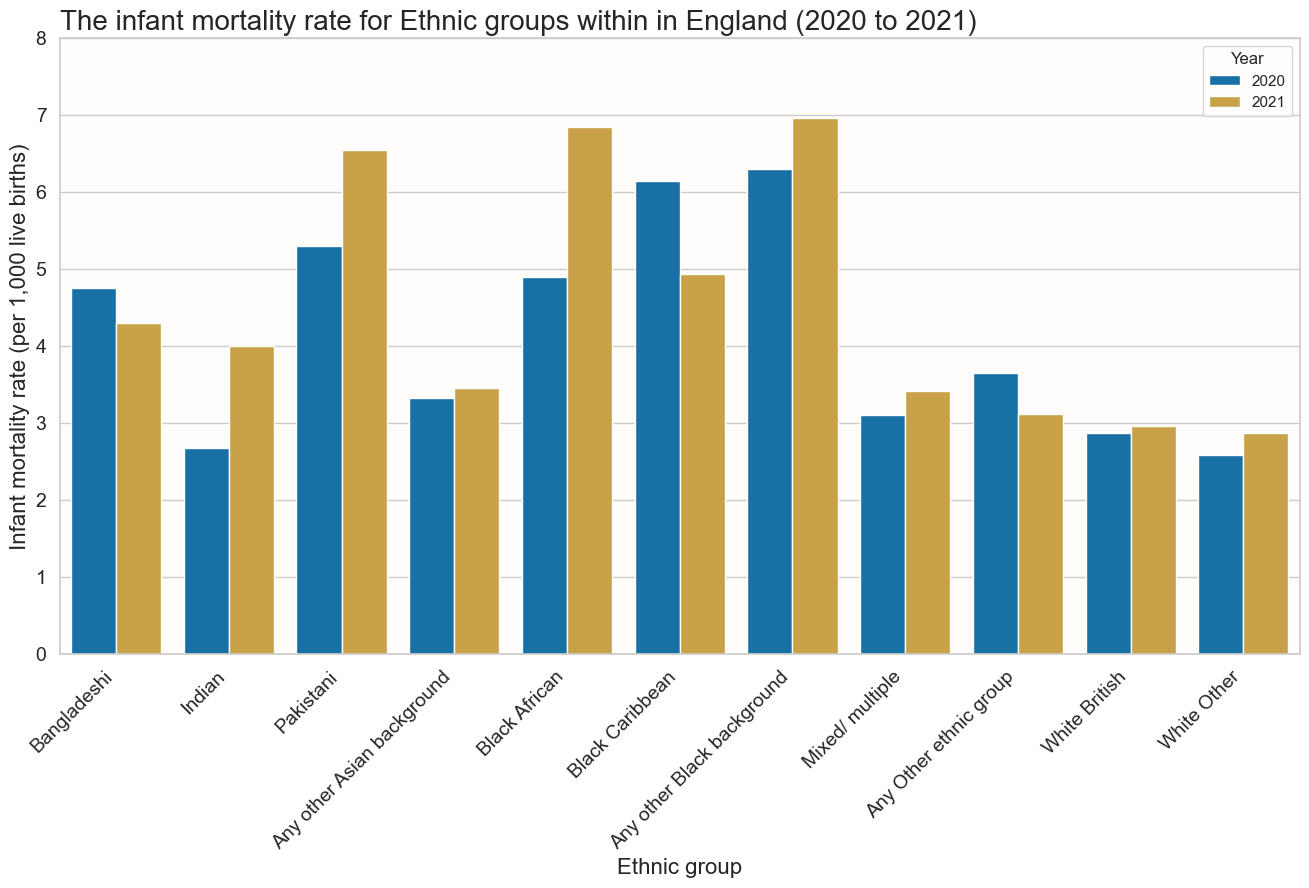

In [54]:

# for horizontal
all_2020 = ethnicity_comb[(ethnicity_comb['Ethnic group'] == 'All') & (ethnicity_comb['Year'] == 2020)]['Infant mortality rate']
all_2021 = ethnicity_comb[(ethnicity_comb['Ethnic group'] == 'All') & (ethnicity_comb['Year'] == 2021)]['Infant mortality rate']


#  do not want All as a bar
ethnicity_comb_filtered = ethnicity_comb[ethnicity_comb['Ethnic group'] != 'All']
plt.figure(figsize=(16, 8))
ethnicity_bar = sns.barplot(x='Ethnic group', y='Infant mortality rate', hue='Year', data=ethnicity_comb_filtered, palette=["#0077bb", "#DDAA33"])

# checkking colouts
for patch in ethnicity_bar.patches:
    bar_facecolor = patch.get_facecolor()
    
    print(f"bar colour: {bar_facecolor}")

# lables
plt.xlabel('Ethnic group', fontsize=16)
plt.ylabel('Infant mortality rate (per 1,000 live births)', fontsize=16)
plt.title('The infant mortality rate for Ethnic groups within in England (2020 to 2021)', fontsize=20, loc='left')
plt.ylim(0, 8)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)

plt.show()


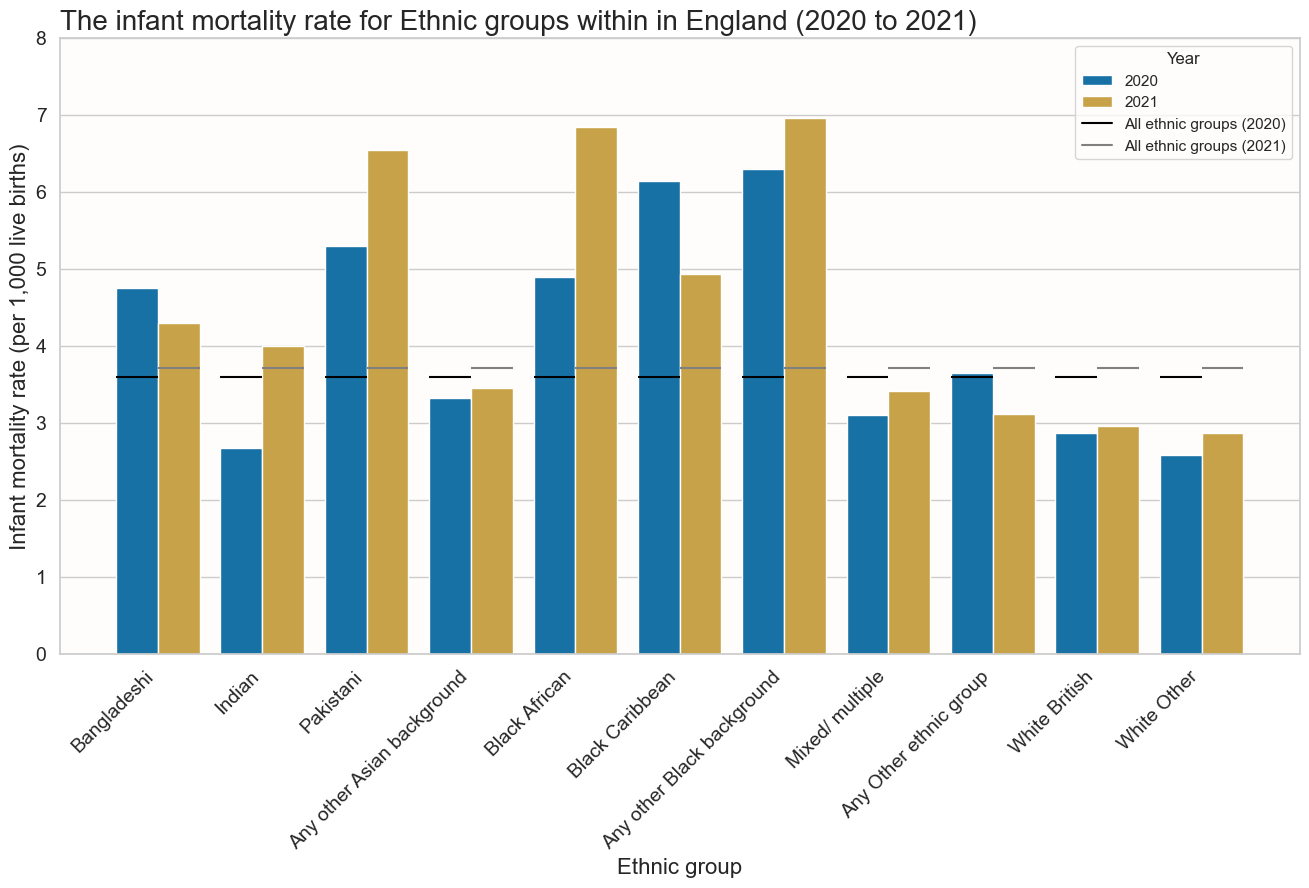

In [55]:
plt.figure(figsize=(16, 8))
eth_bar = sns.barplot(x='Ethnic group', y='Infant mortality rate', hue='Year', data=ethnicity_comb_filtered, palette=["#0077bb", "#DDAA33"],
                     )

for patch in eth_bar.patches:
    x = patch.get_x()
    width = patch.get_width()
    bar_facecolor = patch.get_facecolor()
    
    
    # 2020 colour, else 2021
    if bar_facecolor == (0.09166666666666667, 0.44166666666666665, 0.6416666666666666, 1): 
        plt.hlines(all_2020, x, x + width, colors='black')
    else:
        plt.hlines(all_2021, x, x + width, colors='grey')


plt.xlabel('Ethnic group', fontsize=16)
plt.ylabel('Infant mortality rate (per 1,000 live births)', fontsize=16)
plt.title('The infant mortality rate for Ethnic groups within in England (2020 to 2021)', fontsize=20, loc='left')
plt.ylim(0, 8)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)

# adding All data into legenf
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([plt.Line2D([0], [0], color='black'), plt.Line2D([0], [0], color='grey')])
labels.extend(['All ethnic groups (2020)', 'All ethnic groups (2021)'])
plt.legend(handles, labels,title="Year")

# Show the plot
plt.show()

Cleaning census ethnicity data 

In [56]:
# removing unnecessary columns
cols = [col for col in ethnicity_breakdown.columns if 'Female' in col or col in ['Geography Code', 'Geography Name', 'Age']]
female = ethnicity_breakdown[cols]

# replacing c to 0 so can get numerical form
for col in female.columns:
    if col not in ['Geography Code', 'Geography Name', 'Age']:
        female[col] = female[col].replace('c', 0)

# numerical dorm
for col in female.columns:
    if col not in ['Geography Code', 'Geography Name', 'Age']:
        female[col] = pd.to_numeric(female[col])
females= female[(female['Age'] !='100 or over') &
               (~female['Geography Code'].str.startswith(('K04000001','E92000001',"W")))]
females['Age'] = females['Age'].astype(int)
# gen fertility age 15 to44
females = females[(females['Age'] >= 15) & (females['Age'] <= 44)]

females

,Geography Code,Geography Name,Age,"Asian, Asian British or Asian Welsh: Bangladeshi Female","Asian, Asian British or Asian Welsh: Chinese Female","Asian, Asian British or Asian Welsh: Indian Female","Asian, Asian British or Asian Welsh: Pakistani Female","Asian, Asian British or Asian Welsh: Other Asian Female","Black, Black British, Black Welsh, Caribbean or African: African Female","Black, Black British, Black Welsh, Caribbean or African: Caribbean Female",...,Mixed or Multiple ethnic groups: White and Black African Female,Mixed or Multiple ethnic groups: White and Black Caribbean Female,Mixed or Multiple ethnic groups: Other Mixed or Multiple ethnic groups Female,"White: English, Welsh, Scottish, Northern Irish or British Female",White: Gypsy or Irish Traveller Female,White: Irish Female,White: Roma Female,White: Other White Female,Other ethnic group: Arab Female,Other ethnic group: Any other ethnic group Female
318,E12000001,North East,15,150,55,115,230,90,135,0,...,90,55,75,12450,15,20,20,225,95,70
319,E12000001,North East,16,145,50,130,215,100,190,0,...,80,65,60,12525,20,0,20,205,80,85
320,E12000001,North East,17,145,55,105,255,85,130,0,...,60,50,90,12315,15,15,15,235,80,80
321,E12000001,North East,18,150,120,135,225,115,140,0,...,55,60,90,12850,25,45,25,335,80,95
322,E12000001,North East,19,175,225,170,260,150,170,15,...,65,90,110,14045,20,75,10,610,90,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32158,E09000032,Wandsworth,40,15,60,90,100,125,135,115,...,20,35,55,965,0,55,10,825,35,115
32159,E09000032,Wandsworth,41,15,70,110,90,110,155,75,...,25,35,55,970,0,55,0,790,35,95
32160,E09000032,Wandsworth,42,15,55,70,90,110,185,70,...,15,30,55,870,0,50,15,755,30,90
32161,E09000032,Wandsworth,43,10,50,75,65,155,150,80,...,15,20,35,830,0,45,0,655,25,115


In [57]:

grouped_females = females.groupby(['Geography Code', 'Geography Name']).sum().reset_index()
# age grpup
grouped_females['Age'] = '15-44'

grouped_females


,Geography Code,Geography Name,Age,"Asian, Asian British or Asian Welsh: Bangladeshi Female","Asian, Asian British or Asian Welsh: Chinese Female","Asian, Asian British or Asian Welsh: Indian Female","Asian, Asian British or Asian Welsh: Pakistani Female","Asian, Asian British or Asian Welsh: Other Asian Female","Black, Black British, Black Welsh, Caribbean or African: African Female","Black, Black British, Black Welsh, Caribbean or African: Caribbean Female",...,Mixed or Multiple ethnic groups: White and Black African Female,Mixed or Multiple ethnic groups: White and Black Caribbean Female,Mixed or Multiple ethnic groups: Other Mixed or Multiple ethnic groups Female,"White: English, Welsh, Scottish, Northern Irish or British Female",White: Gypsy or Irish Traveller Female,White: Irish Female,White: Roma Female,White: Other White Female,Other ethnic group: Arab Female,Other ethnic group: Any other ethnic group Female
0,E06000001,Hartlepool,15-44,0,0,0,0,25,10,0,...,0,0,0,15555,0,0,0,190,0,0
1,E06000002,Middlesbrough,15-44,10,40,665,2245,475,875,0,...,20,10,30,21020,0,0,0,1015,255,410
2,E06000003,Redcar and Cleveland,15-44,0,0,0,0,0,0,0,...,0,0,0,21530,0,0,0,255,0,0
3,E06000004,Stockton-on-Tees,15-44,0,75,390,1230,295,440,0,...,10,0,130,30745,0,0,25,685,35,130
4,E06000005,Darlington,15-44,50,0,120,0,45,10,0,...,0,10,0,16495,10,0,0,1065,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,E12000005,West Midlands,15-44,20960,10050,64060,81580,21975,40875,18195,...,3135,20170,7585,708165,1405,4905,1830,79010,7925,21950
312,E12000006,East of England,15-44,13570,10370,33750,24740,22015,31760,8230,...,5080,12075,10895,820380,1925,7705,2545,130975,3680,17510
313,E12000007,London,15-44,86790,49865,153590,69600,101700,177910,73115,...,18120,34935,43910,642710,1755,27610,11490,416335,34360,104970
314,E12000008,South East,15-44,10605,18180,60030,35945,42140,40255,8805,...,7360,14485,16600,1213260,3555,10720,3335,180370,7175,26345


In [58]:

# assign proportions
proportion = [col for col in grouped_females.columns if col not in ['Geography Code', 'Geography Name', 'Age']]
grouped_females[proportion] = grouped_females.apply(ethnicity_proportions, axis=1)

# transpose
gf = pd.melt(grouped_females, id_vars=['Geography Name', 'Geography Code', 'Age'], var_name='Ethnicity', value_name='Proportion')

gf


,Geography Name,Geography Code,Age,Ethnicity,Proportion
0,Hartlepool,E06000001,15-44,"Asian, Asian British or Asian Welsh: Banglades...",0.000000
1,Middlesbrough,E06000002,15-44,"Asian, Asian British or Asian Welsh: Banglades...",0.036765
2,Redcar and Cleveland,E06000003,15-44,"Asian, Asian British or Asian Welsh: Banglades...",0.000000
3,Stockton-on-Tees,E06000004,15-44,"Asian, Asian British or Asian Welsh: Banglades...",0.000000
4,Darlington,E06000005,15-44,"Asian, Asian British or Asian Welsh: Banglades...",0.280034
...,...,...,...,...,...
5999,West Midlands,E12000005,15-44,Other ethnic group: Any other ethnic group Female,1.944879
6000,East of England,E12000006,15-44,Other ethnic group: Any other ethnic group Female,1.495035
6001,London,E12000007,15-44,Other ethnic group: Any other ethnic group Female,4.986130
6002,South East,E12000008,15-44,Other ethnic group: Any other ethnic group Female,1.530858


In [59]:
B_A = gf[gf['Ethnicity'].str.startswith(('Asian, Asian British', 'Black, Black British'))]
BA_total = B_A.groupby(['Geography Name', 'Geography Code', 'Age']).agg({'Proportion': 'sum'}).reset_index()

BA_total

,Geography Name,Geography Code,Age,Proportion
0,Adur,E07000223,15-44,0.106101
1,Allerdale,E07000026,15-44,0.000000
2,Amber Valley,E07000032,15-44,0.050277
3,Arun,E07000224,15-44,0.440529
4,Ashfield,E07000170,15-44,1.396840
...,...,...,...,...
311,Wychavon,E07000238,15-44,0.126454
312,Wyre,E07000128,15-44,0.000000
313,Wyre Forest,E07000239,15-44,0.198413
314,York,E06000014,15-44,6.736527


In [60]:
BA_total.rename(columns={'Geography Code': 'GEOGRAPHY_CODE'},inplace=True)
eth= pd.merge(IMD_LSOA, BA_total, on=['GEOGRAPHY_CODE'])
y = eth["Infant mortality rate"]

X = eth[["IMD_average","Proportion"]]

X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())


                              OLS Regression Results                             
Dep. Variable:     Infant mortality rate   R-squared:                       0.301
Model:                               OLS   Adj. R-squared:                  0.281
Method:                    Least Squares   F-statistic:                     15.08
Date:                   Sun, 02 Jun 2024   Prob (F-statistic):           3.58e-06
Time:                           21:23:41   Log-Likelihood:                -112.15
No. Observations:                     73   AIC:                             230.3
Df Residuals:                         70   BIC:                             237.2
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.84

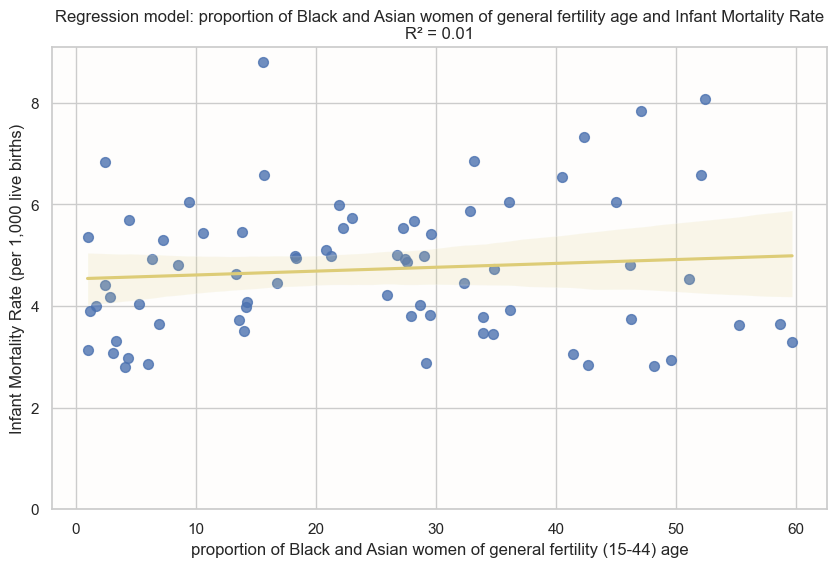

pearsons correlation: 0.0933675389866243


In [61]:
y = eth["Infant mortality rate"]
X = eth["Proportion"]
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()
r_squared = model.rsquared


plt.figure(figsize=(10, 6))
sns.regplot(x='Proportion', y='Infant mortality rate',
            data=eth, scatter_kws={'s': 50,
                                  },
            line_kws={'color': '#DDCC77'})
plt.title('Regression model: proportion of Black and Asian women of general fertility age and Infant Mortality Rate\n' + f'R² = {r_squared:.2f}')
plt.xlabel('proportion of Black and Asian women of general fertility (15-44) age')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')

#plt.xlim(0)
plt.ylim(0)
plt.grid(True)
plt.show()
print('pearsons correlation:',stats.pearsonr(eth["Infant mortality rate"],eth["Proportion"])[0])

In [62]:
eth_worse=eth[eth['GEOGRAPHY_NAME_x'].isin(["Stoke-on-Trent", "Staffordshire",'Sandwell', 
                                     'Birmingham', 'Coventry', 'Bradford', 'Kirklees', 'Doncaster'])]

eth_worse

,Interval,GEOGRAPHY_NAME_x,GEOGRAPHY_CODE,Live births,GEOGRAPHY_NAME_y,Deaths,Infant mortality rate,lower_ci,upper_ci,IMD_average,Colour,Geography Name,Age,Proportion
5,2021-2022,Birmingham,E08000025,28959,Birmingham,227,7.838668,6.852006,8.927488,38.067,#AA4499,Birmingham,15-44,47.054945
10,2021-2022,Bradford,E08000032,13512,Bradford,99,7.326821,5.954738,8.920226,34.666,#332288,Bradford,15-44,42.347354
19,2021-2022,Coventry,E08000026,8007,Coventry,47,5.869864,4.312584,7.805851,25.613,#AA4499,Coventry,15-44,32.814054
22,2021-2022,Doncaster,E08000017,6683,Doncaster,38,5.686069,4.023293,7.804793,30.289,#332288,Doncaster,15-44,4.397723
34,2021-2022,Kirklees,E08000034,9528,Kirklees,54,5.667506,4.257318,7.395010,25.151,#332288,Kirklees,15-44,28.157576
56,2021-2022,Sandwell,E08000028,8557,Sandwell,56,6.544350,4.943219,8.498541,34.884,#AA4499,Sandwell,15-44,40.500503
61,2021-2022,Stoke-on-Trent,E06000021,6026,Stoke-on-Trent,53,8.795221,6.587765,11.504593,34.504,#AA4499,Stoke-on-Trent,15-44,15.608170


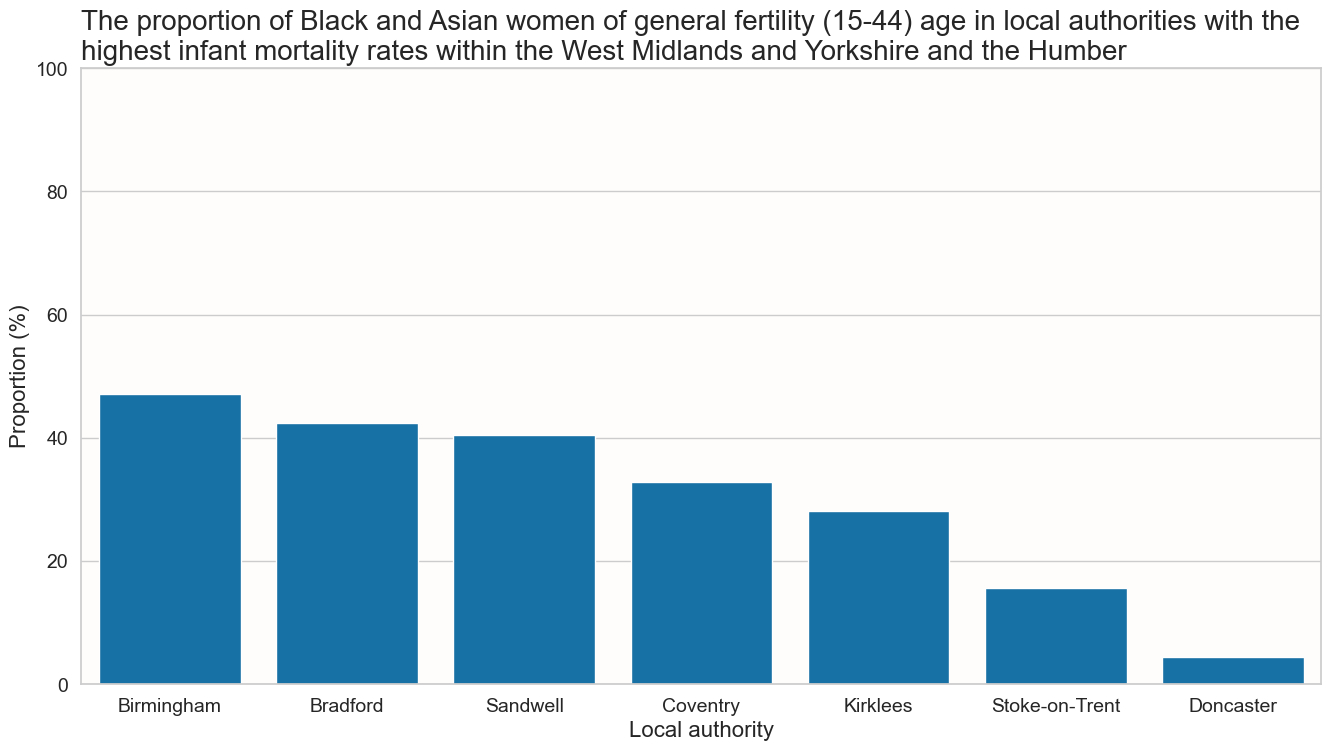

In [63]:
plt.figure(figsize=(16, 8))

sns.barplot(x='GEOGRAPHY_NAME_y',
            y="Proportion", data=eth_worse, 
            order=eth_worse.sort_values('Proportion',ascending = False).GEOGRAPHY_NAME_y,color="#0077bb")

plt.xlabel('Local authority',fontsize=16)
plt.ylabel('Proportion (%)',fontsize=16)
plt.title("""The proportion of Black and Asian women of general fertility (15-44) age in local authorities with the 
highest infant mortality rates within the West Midlands and Yorkshire and the Humber """,fontsize=20, loc='left')
plt.ylim(0,100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


# Bibliography

Holtz, Y. (n.d.). Slope chart and parallel plot. [online] The Python Graph Gallery. Available at: https://python-graph-gallery.com/web-slope-chart-matplotlib/ [Accessed 31 May 2024].

Bobbitt, Z (2020). A Complete Guide to Linear Regression in Python. [online] Statology. Available at: https://www.statology.org/linear-regression-python/.

Bobbitt, Z (2020). How to Perform a Breusch-Pagan Test in Python. [online] Statology. Available at: https://www.statology.org/breusch-pagan-test-python/.


Bobbitt, Z (2020). How to Create a Q-Q Plot in Python. [online] Statology. Available at: https://www.statology.org/q-q-plot-python/.

matplotlib.org. (n.d.). Axes and subplots — Matplotlib 3.8.2 documentation. [online] Available at: https://matplotlib.org/stable/users/explain/axes/index.html.

matplotlib.org. (n.d.). matplotlib.offsetbox — Matplotlib 3.9.0 documentation. [online] Available at: https://matplotlib.org/stable/api/offsetbox_api.html#matplotlib.offsetbox.AnnotationBbox [Accessed 31 May 2024].

matplotlib.org. (n.d.). matplotlib.patches.Patch — Matplotlib 3.9.0 documentation. [online] Available at: https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html#examples-using-matplotlib-patches-patch [Accessed 31 May. 2024].


ONS (2023). Open Geography portal. [online] geoportal.statistics.gov.uk. Available at: https://geoportal.statistics.gov.uk/.


www.nomisweb.co.uk. (n.d.). Dataset Selection - Query - Nomis - Official Census and Labour Market Statistics. [online] Available at: https://www.nomisweb.co.uk/query/select/getdatasetbytheme.asp?theme=73.

Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021.
